In [1]:
import copy
import sys
import random
import pickle
import torch
import warnings
import logging
import gc
import math
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pytorch_optimizer as optim_mod

from torch.optim import Optimizer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from collections import Counter
from tqdm import tqdm
from sklearn.exceptions import UndefinedMetricWarning

from torch.cuda.amp import autocast, GradScaler
from IPython.display import display, HTML

from collections import defaultdict
from sklearn.model_selection import StratifiedKFold

from scipy.stats import mode

from IPython.display import Javascript, display


warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

general_logger = logging.getLogger('general_logger')
general_handler = logging.FileHandler('NoForceTransformers_log.txt', mode='w')
general_handler.setFormatter(logging.Formatter('%(message)s'))
general_logger.setLevel(logging.INFO)
general_logger.addHandler(general_handler)


# HTML and JavaScript for auto-scrolling and manual scroll control
display(HTML('''
    <style>
        .output_scroll {
            max-height: 300px;  /* Set the fixed height */
            overflow-y: scroll; /* Ensure scrolling within the defined height */
            resize: none;       /* Disable resizing by the user */
        }
    </style>

    <script>
        var autoScrollEnabled = true;
        var userScroll = false;

        function autoScrollOutput() {
            if (autoScrollEnabled && !userScroll) {
                var output = document.querySelectorAll('.output_scroll');
                if (output.length) {
                    output[output.length - 1].scrollIntoView({ behavior: 'smooth', block: 'end' });
                }
            }
        }

        function stopAutoScroll() {
            autoScrollEnabled = false;
        }

        // Detect when the user manually scrolls to disable auto-scrolling
        document.querySelector('.output_scroll').addEventListener('scroll', function() {
            userScroll = true;
        }, { passive: true });

        // Reset scroll control when needed (manually call this at the end of an epoch)
        function resetAutoScroll() {
            userScroll = false;
            autoScrollEnabled = true;
        }

        // Manual trigger for scrolling at the end of the epoch
        function scrollToEnd() {
            autoScrollEnabled = true;
            autoScrollOutput();
        }
    </script>
'''))

# Function to trigger scrollToEnd in JavaScript
def scroll_to_end():
    display(Javascript('scrollToEnd();'))
    display(Javascript('resetAutoScroll();'))

def log(message):
    general_logger.info(message) 
    print(message)     


In [2]:
gc.collect()

seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
log(f"Using device: {device}")

Using device: cuda


In [3]:
# Load the sequences and labels arrays
loaded_data_sequences = np.load('sequence_array_filtered_TRAINING3.npz', allow_pickle=True)
loaded_data_labels = np.load('label_array_filtered_TRAINING3.npz', allow_pickle=True)

# Access the saved arrays
sequence_array = loaded_data_sequences['sequences']
label_array = loaded_data_labels['labels']

print("Arrays loaded successfully!")

sequence_array.shape[:]


Arrays loaded successfully!


(183715, 33, 307)

In [4]:
print(sequence_array.shape[:])
print(label_array.shape[:])


(183715, 33, 307)
(183715, 33)


In [5]:
# Remove the first feature (client ID) from the sequence array and the last two timesteps
sequence_array = sequence_array[:, :-2, 1:]  # Remove client ID (first feature) and last two timesteps
label_array = label_array[:, :-2]  # Remove the last two timesteps from the label array

print("Shapes after cleaning:")
print("sequence_array_cleaned shape:", sequence_array.shape)
print("label_array_cleaned shape:", label_array.shape)

Shapes after cleaning:
sequence_array_cleaned shape: (183715, 31, 306)
label_array_cleaned shape: (183715, 31)


In [6]:
label_array[4]

array(['OUT', 'OUT', 'OUT', 'OUT', 'OUT', 'OUT', 'OUT', 'OUT', 'OUT',
       'OUT', 'OUT', 'OUT', 'OUT', 'OUT', 'OUT', 'OUT', 'OUT', 'CONTINUA',
       'CONTINUA', 'CONTINUA', 'CONTINUA', 'CONTINUA', 'CONTINUA',
       'CONTINUA', 'CONTINUA', 'CONTINUA', 'CONTINUA', 'CONTINUA',
       'CONTINUA', 'CONTINUA', 'CONTINUA'], dtype='<U8')

In [7]:
def plot_training_metrics(epochs_list, train_loss_values, loss_values, ganancia_values, threshold_values):

    plt.figure(figsize=(6, 6))
    
    # Plotting Train Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs_list, train_loss_values, label='Train Loss', marker='o')
    plt.title(f'Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, max(train_loss_values) + 0.1)
    plt.legend()

    # Plotting Best Test Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_list, loss_values, label='Best Test Loss', marker='o')
    plt.title(f'Val Over')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.ylim(0, max(loss_values) + 0.1)
    plt.legend()

    # Plotting Best Ganancia
    plt.subplot(2, 2, 3)
    plt.plot(epochs_list, ganancia_values, label='Best Ganancia', marker='o', color='green')
    plt.title(f'Ganancia')
    plt.xlabel('Epochs')
    plt.ylabel('Ganancia')
    plt.ylim(0, max(ganancia_values) + 0.1)
    plt.legend()

    # Plotting Threshold Values
    plt.subplot(2, 2, 4)
    plt.plot(epochs_list, threshold_values, label='Threshold Values', marker='o', color='green')
    plt.title(f'Threshold')
    plt.xlabel('Epochs')
    plt.ylabel('Threshold')
    plt.ylim(0, max(threshold_values) + 0.1)
    plt.legend()

    plt.tight_layout()

    plt.savefig(f"NOFORCE_training_metrics.png")
    
    plt.show()
    plt.close()


In [8]:
def split_data(sequence_array, label_array, train_steps, val_steps, test_steps):
    num_timesteps = sequence_array.shape[1]  # Total number of time steps

    # Ensure there are enough steps for training, validation, and testing
    assert train_steps + val_steps + test_steps <= num_timesteps, "Not enough steps for train/val/test."

    # Train on the first `train_steps` time steps (view without copying memory)
    X_train = sequence_array[:, :train_steps, :]  # Shape: [batch_size, 27, num_features]
    y_train = label_array[:, :train_steps]        # Shape: [batch_size, 27]

    # Validation on the first `train_steps + val_steps` time steps
    X_val = sequence_array[:, :train_steps + val_steps, :]  # Shape: [batch_size, 29, num_features]
    y_val = label_array[:, :train_steps + val_steps]        # Shape: [batch_size, 29]

    # Test on the entire sequence (31 steps)
    X_test = sequence_array[:, :train_steps + val_steps + test_steps, :]  # Shape: [batch_size, 31, num_features]
    y_test = label_array[:, :train_steps + val_steps + test_steps]        # Shape: [batch_size, 31]

    return X_train, y_train, X_val, y_val, X_test, y_test


In [9]:
def create_padding_mask(input_seq, pad_token=0):
    # Check if all features in a time step are equal to pad_token
    mask = (input_seq != pad_token).any(dim=-1).bool().transpose(0, 1)  # Shape: [seq_len, batch_size]
    
    return mask

def create_padding_mask(input_seq, pad_token=0):
    # Check if all features in a time step are equal to pad_token
    mask = (input_seq != pad_token).any(dim=-1).bool().transpose(0, 1)  # Shape: [seq_len, batch_size]
    
    return mask


In [10]:
class CustomGananciaLossWorks(nn.Module):
    def __init__(self, class_weights=None, baja_2_multiplier=2.0, alpha=2.0, epsilon=1e-5, init_threshold=0.01, threshold_penalty_weight=0.1):
        super(CustomGananciaLoss, self).__init__()
        self.ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        self.baja_2_multiplier = baja_2_multiplier
        self.alpha = alpha  # Controls how much custom loss should impact
        self.epsilon = epsilon  # Small value to prevent division by zero

        # Trainable threshold for BAJA+2 classification
        self.baja_2_threshold = nn.Parameter(torch.tensor(init_threshold))  # Initialize with 0.5, but can be learned
        
        # Penalty weight for low threshold
        self.threshold_penalty_weight = threshold_penalty_weight

    def forward(self, outputs, targets):
        # Outputs shape is [batch_size, seq_len, num_classes]
        batch_size, seq_len, num_classes = outputs.shape

        # Standard Cross-Entropy Loss
        ce_loss = self.ce_loss_fn(outputs.reshape(-1, num_classes), targets.reshape(-1))

        # Calculate probabilities for "BAJA+2" (class index 1)
        baja_2_probs = F.softmax(outputs, dim=-1)[:, :, 1]  # [batch_size, seq_len]

        # Apply the trainable threshold to make predictions for "BAJA+2"
        threshold = torch.clamp(self.baja_2_threshold, 0.01, 0.99)  # Ensure the threshold is in a valid range

        predicted_baja_2 = (baja_2_probs > threshold).float()

        # Check if the target is "BAJA+2"
        is_baja_2 = (targets == 1).float()
        is_not_baja_2 = (targets != 1).float()

        # Calculate expected ganancia
        expected_ganancia = 117 * predicted_baja_2 * is_baja_2 - 3 * predicted_baja_2 * is_not_baja_2
        custom_loss = -expected_ganancia.mean()

        threshold_penalty = self.threshold_penalty_weight * (1 / (threshold + self.epsilon))  # Penalty stronger for low thresholds

        # Ratio between custom loss and CE loss
        ratio = (self.alpha * custom_loss) / (ce_loss + self.epsilon)

        # Apply sigmoid to get a smooth weight
        weight = torch.sigmoid(ratio)

        # Combine CE loss, custom loss, and threshold penalty
        total_loss = weight * self.alpha * custom_loss + (1 - weight) * ce_loss + threshold_penalty

        return total_loss, ce_loss, custom_loss, weight, threshold


class CustomGananciaLoss(nn.Module):
    def __init__(self, class_weights=None, baja_2_multiplier=2.0, alpha=4.0, epsilon=1e-5, init_threshold=0.01, threshold_penalty_weight=0.1):
        super(CustomGananciaLoss, self).__init__()
        self.ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        self.baja_2_multiplier = baja_2_multiplier
        self.alpha = alpha  # Controls how much custom loss should impact
        self.epsilon = epsilon  # Small value to prevent division by zero

        # Trainable threshold for BAJA+2 classification
        self.baja_2_threshold = nn.Parameter(torch.tensor(init_threshold))  # Initialize with 0.01, but can be learned
        
        # Penalty weight for low threshold
        self.threshold_penalty_weight = threshold_penalty_weight

    def forward(self, outputs, targets):
        # Outputs shape is [batch_size, seq_len, num_classes]
        batch_size, seq_len, num_classes = outputs.shape

        # Standard Cross-Entropy Loss
        ce_loss = self.ce_loss_fn(outputs.reshape(-1, num_classes), targets.reshape(-1))

        # Calculate probabilities for "BAJA+2" (class index 1)
        baja_2_probs = F.softmax(outputs, dim=-1)[:, :, 1]  # [batch_size, seq_len]

        # Get soft probabilities for argmax (using softmax to avoid hard argmax)
        softmax_probs = F.softmax(outputs, dim=-1)

        # Calculate the mask: apply threshold only where BAJA+2 was not the highest probability
        threshold = torch.clamp(self.baja_2_threshold, 0.01, 0.99)
        predicted_baja_2_probs = torch.sigmoid((baja_2_probs - threshold) * 10)  # Sigmoid to smooth threshold application

        # Get the max probability per class using softmax (instead of argmax)
        max_class_probs, max_class_indices = softmax_probs.max(dim=-1)  # [batch_size, seq_len]

        # Apply the soft threshold only to instances where BAJA+2 wasn't the max predicted class
        baja_2_mask = (max_class_indices != 1).float()  # Mask for classes that are not BAJA+2
        final_baja_2_probs = baja_2_mask * predicted_baja_2_probs

        # Check if the target is "BAJA+2"
        is_baja_2 = (targets == 1).float()
        is_not_baja_2 = (targets != 1).float()

        # Calculate expected ganancia based on the masked predictions
        expected_ganancia = 117 * final_baja_2_probs * is_baja_2 - 3 * final_baja_2_probs * is_not_baja_2
        custom_loss = -expected_ganancia.mean()

        # Penalty for low threshold
        threshold_penalty = self.threshold_penalty_weight * (1 / (threshold + self.epsilon))  # Penalty stronger for low thresholds

        # Ratio between custom loss and CE loss
        ratio = (self.alpha * custom_loss) / (ce_loss + self.epsilon)

        # Apply sigmoid to get a smooth weight
        weight = torch.sigmoid(ratio)

        # Combine CE loss, custom loss, and threshold penalty
        total_loss = self.alpha * custom_loss + (0.001) * ce_loss #+ threshold_penalty

        return total_loss, ce_loss, custom_loss, weight, threshold


import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomGananciaLoss(nn.Module):
    def __init__(self, class_weights=None, alpha=4.0, missing_baja_2_penalty_weight=1.0):
        super(CustomGananciaLoss, self).__init__()
        self.ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights)
        self.alpha = alpha  # Controls how much custom loss should impact
        self.missing_baja_2_penalty_weight = missing_baja_2_penalty_weight

    def forward(self, outputs, targets):
        # Outputs shape is [batch_size, seq_len, num_classes]
        batch_size, seq_len, num_classes = outputs.shape

        # Standard Cross-Entropy Loss
        ce_loss = self.ce_loss_fn(outputs.reshape(-1, num_classes), targets.reshape(-1))

        # Calculate probabilities for "BAJA+2" (class index 1)
        baja_2_probs = F.softmax(outputs, dim=-1)[:, :, 1]  # [batch_size, seq_len]

        # Check if the target is "BAJA+2"
        is_baja_2 = (targets == 1).float()
        is_not_baja_2 = (targets != 1).float()

        # Calculate expected ganancia without masking
        expected_ganancia = 117 * baja_2_probs * is_baja_2 - 3 * baja_2_probs * is_not_baja_2

        # Add penalty for missing BAJA+2 predictions
        missing_baja_2_penalty = self.missing_baja_2_penalty_weight * (1 - baja_2_probs) * is_baja_2

        # Compute custom loss
        custom_loss = -expected_ganancia.mean() + missing_baja_2_penalty.mean()

        # Combine CE loss and custom loss
        total_loss = self.alpha * custom_loss + ce_loss

        weight= expected_ganancia
        threshold=missing_baja_2_penalty

        return total_loss, ce_loss, custom_loss, weight, threshold





In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=33):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)  # Shape: (1, max_len, d_model)

    def forward(self, x):
        # Ensure self.encoding is on the same device as x
        encoding = self.encoding.to(x.device)  # Move encoding to the same device as x
        #print(f"Positional Encoding Input Shape: {x.shape}")
        x = x + encoding[:, :x.size(1), :]  # Add positional encoding to input
        #print(f"Positional Encoding Output Shape: {x.shape}")
        return x


class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=512, num_heads=8, num_layers=6, num_classes=4, dim_feedforward=2048, dropout=0.2):
        super(TransformerModel, self).__init__()
        
        # Linear projection to project input_dim (306) to d_model (512)
        self.linear_proj = nn.Linear(input_dim, d_model)
        
        # Positional encoding for d_model (512)
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Transformer encoder with a feedforward network
        encoder_layers = nn.TransformerEncoderLayer(d_model, num_heads, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        
        # Additional feedforward network after transformer encoder
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
            nn.ReLU()
        )
        
        # Final fully connected layer for classification
        self.fc = nn.Linear(d_model, num_classes)  # Output is number of classes

    def forward(self, src, src_key_padding_mask=None):
        # Project input to match the d_model (512 dimensions)
        src = self.linear_proj(src)  # Shape: [batch_size, seq_len, d_model]

        # Apply positional encoding
        src = self.pos_encoder(src)  # Shape remains: [batch_size, seq_len, d_model]

        # Pass through the transformer encoder
        output = self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask)

        # Apply feedforward network
        output = self.feedforward(output)  # Shape remains: [batch_size, seq_len, d_model]

        # Pass through the final fully connected layer for classification
        output = self.fc(output)  # Shape: [batch_size, seq_len, num_classes]

        return output  # Output predictions for each time step


In [12]:
def train_model_with_teacher_forcing(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, pad_value=0, device='cuda'):
    # Move the model to the specified device (GPU if available)
    model = model.to(device)

    # Initialize variables to track the best metrics
    best_val_loss = float('inf')
    best_ganancia_epoch = float('-inf')

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=10, verbose=True, threshold=0.0001)

    ganancia_values = []
    train_loss_values = []
    val_loss_values = []
    threshold_values = []
    epochs_list = []
  
    for epoch in range(num_epochs):
        epochs_list.append(epoch + 1) 
        model.train()
        train_loss = 0.0

        # Use tqdm to wrap the training loop
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=True, ncols=150)

        for batch in progress_bar:
            X_batch, y_batch = batch

            # Move data to the device
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            optimizer.zero_grad()

            # Initial mask based on the entire sequence
            batch_size, seq_len, _ = X_batch.shape
            src_key_padding_mask = create_padding_mask(X_batch, pad_value).to(device)

            # Forward pass: Predict for all time steps
            outputs = model(X_batch, src_key_padding_mask)  # [batch_size, seq_len, num_classes]

            # Compute loss for all time steps
            total_loss, ce_loss, custom_loss, weight, threshold = criterion(outputs, y_batch)
            train_loss += total_loss.item()

            # Backward pass and optimization
            total_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()

            # Update progress bar with CE loss, custom loss, and weight
            progress_bar.set_postfix({
                "Train Loss": train_loss / len(train_loader),
                "CE Loss": ce_loss.item(),
                "Custom Loss": custom_loss.item(),
                "Weight": weight.item(),
                "T": threshold.item()
            })

        train_loss /= len(train_loader)

        # Validation loop
        val_loss, best_ganancia, best_threshold = validation_loop(model, val_loader, criterion, pad_value, device)

        # Check if there were improvements
        val_loss_improved = val_loss < best_val_loss
        ganancia_improved = best_ganancia > best_ganancia_epoch
        
        ganancia_values.append(best_ganancia)
        train_loss_values.append(train_loss)
        val_loss_values.append(val_loss)
        threshold_values.append(best_threshold)
        

        # Update best_val_loss and best_ganancia_epoch if improved
        if val_loss_improved:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model_val_loss.pth')
            print(f'Saving model with best validation loss: {best_val_loss:.4f}')

        if ganancia_improved:
            best_ganancia_epoch = best_ganancia
            torch.save(model.state_dict(), 'best_model_ganancia.pth')
            print(f'Saving model with best ganancia: {best_ganancia_epoch}')

        # Step the scheduler only if there were no improvements in both metrics
        if not val_loss_improved and not ganancia_improved:
            print("LR Stepping in!")
            scheduler.step(val_loss)


        current_lr = optimizer.param_groups[0]['lr']
        # Print epoch results
        print("")
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Ganancia: {best_ganancia}, Threshold: {best_threshold:.2f}, LR: {current_lr}')

        plot_training_metrics(epochs_list, train_loss_values, val_loss_values, ganancia_values, threshold_values)

    print('Training complete.')


In [13]:
def validation_loop(model, val_loader, criterion, pad_value, device, thresholds=np.arange(0.01, 0.99, 0.01)):
    val_loss = 0.0
    all_preds_last2 = []
    all_labels_last2 = []
    all_probs_last2 = []
    model.eval()

    with torch.no_grad():
        progress_bar = tqdm(val_loader, desc="Validation", leave=False)

        for batch in progress_bar:
            X_val_batch, y_val_batch = batch

            # Move validation data to the device
            X_val_batch = X_val_batch.to(device)
            y_val_batch = y_val_batch.to(device)

            # Create the validation mask
            #val_key_padding_mask = create_padding_mask(X_val_batch[:, :, 0], pad_value).to(device)
            val_key_padding_mask = create_padding_mask(X_val_batch, pad_value).to(device)

            # Forward pass
            val_outputs = model(X_val_batch, val_key_padding_mask)  # Outputs shape: [batch_size, seq_len, num_classes]

            # Calculate validation loss for all timesteps
            #loss = criterion(val_outputs, y_val_batch)
            total_loss, ce_loss, custom_loss, weight, threshold = criterion(val_outputs, y_val_batch)
            val_loss += total_loss.item()

            # Slice outputs and targets for the last 2 timesteps
            val_outputs_last2 = val_outputs[:, -2:, :]  # Shape: [batch_size, 2, num_classes]
            y_val_batch_last2 = y_val_batch[:, -2:]  # Shape: [batch_size, 2]

            # Get probabilities for the last timestep
            last_timestep_probs = val_outputs_last2[:, -1, :]  # Shape: [batch_size, num_classes]

            # Collect predicted probabilities and labels
            all_probs_last2.append(last_timestep_probs.cpu().numpy())
            all_labels_last2.append(y_val_batch_last2[:, -1].cpu().numpy())  # Collect the labels for the last timestep

        val_loss /= len(val_loader)

        # Convert lists to arrays for threshold sweep
        all_probs_last2 = np.concatenate(all_probs_last2)
        all_labels_last2 = np.concatenate(all_labels_last2)

        # Perform threshold sweep to find the best threshold
        best_ganancia, best_threshold, best_preds = calculate_best_threshold_ganancia(all_probs_last2, all_labels_last2, thresholds)

        # Print classification report for the last timestep
        print("\nClassification Report for Last Timestep with Best Threshold:")
        print(classification_report(all_labels_last2, best_preds, target_names=['BAJA+1', 'BAJA+2', 'CONTINUA', 'OUT']))

        # Count the number of each predicted class
        class_counts = Counter(best_preds)
        ordered_classes = ['BAJA+1', 'BAJA+2', 'CONTINUA', 'OUT']

        # Print class counts in the same order as class names
        print("\nClass Counts (Predicted for Last Timestep):")
        for class_name in ordered_classes:
            class_index = ordered_classes.index(class_name)
            print(f"{class_name}: {class_counts[class_index]}")


        return val_loss, best_ganancia, best_threshold


def calculate_best_threshold_gananciaNOMASK(pred_probs, labels, thresholds, baja_2_index=1):

    best_ganancia = float('-inf')
    best_threshold = 0.69
    best_preds = None

    for threshold in thresholds:
        # Make predictions using the current threshold for BAJA+2
        preds = np.argmax(pred_probs, axis=-1)  # Default argmax predictions
        baja_2_probs = pred_probs[:, baja_2_index]  # BAJA+2 probabilities

        # Apply the threshold for BAJA+2 classification
        preds[baja_2_probs >= threshold] = baja_2_index

        # Calculate ganancia for this threshold
        ganancia = calculate_ganancia(preds, labels)

        # Update if this threshold gives a better ganancia
        if ganancia > best_ganancia:
            best_ganancia = ganancia
            best_threshold = threshold
            best_preds = preds

    return best_ganancia, best_threshold, best_preds


def calculate_best_threshold_ganancia(pred_probs, labels, thresholds, baja_2_index=1):

    best_ganancia = float('-inf')
    best_threshold = 0.69
    best_preds = None

    for threshold in thresholds:
        # Make predictions using the argmax
        preds = np.argmax(pred_probs, axis=-1)  # Default argmax predictions
        baja_2_probs = pred_probs[:, baja_2_index]  # BAJA+2 probabilities

        # Apply the threshold only for predictions that are NOT the relevant class (BAJA+2)
        non_relevant_mask = preds != baja_2_index  # Mask for predictions that are not BAJA+2
        preds[(baja_2_probs >= threshold) & non_relevant_mask] = baja_2_index

        # Calculate ganancia for this threshold
        ganancia = calculate_ganancia(preds, labels)

        # Update if this threshold gives a better ganancia
        if ganancia > best_ganancia:
            best_ganancia = ganancia
            best_threshold = threshold
            best_preds = preds
            #print(f"Best G: {best_ganancia}, T:{best_threshold}")

    return best_ganancia, best_threshold, best_preds



def calculate_ganancia(preds, labels, baja_2_index=1):
    
    # Define reward for correct BAJA+2 and penalty for incorrect BAJA+2
    reward_baja_2 = 117
    penalty_baja_2 = -3

    # Convert predictions and labels to numpy arrays if they aren't already
    preds = np.array(preds)
    labels = np.array(labels)

    # Calculate the number of correct BAJA+2 predictions
    correct_baja_2 = np.sum((preds == baja_2_index) & (labels == baja_2_index))

    # Calculate the number of incorrect BAJA+2 predictions (predicted BAJA+2 but label is not BAJA+2)
    incorrect_baja_2 = np.sum((preds == baja_2_index) & (labels != baja_2_index))

    # Calculate the total ganancia
    ganancia = (reward_baja_2 * correct_baja_2) + (penalty_baja_2 * incorrect_baja_2)

    return ganancia

In [14]:
train_steps = 29
val_steps = 2
test_steps = 0  # Remaining steps for testing

X_train, y_train, X_val, y_val, X_test, y_test = split_data(sequence_array, label_array, train_steps, val_steps, test_steps)

# Encode labels for training, validation, and testing
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.flatten()).reshape(y_train.shape)
y_val_encoded = label_encoder.transform(y_val.flatten()).reshape(y_val.shape)
y_test_encoded = label_encoder.transform(y_test.flatten()).reshape(y_test.shape)

# Print encoded class names and their mappings (optional for debugging)
class_names = label_encoder.classes_
class_mapping = {idx: class_name for idx, class_name in enumerate(class_names)}
print(f"Encoded Classes: {class_names}")
print(f"Class to Index Mapping: {class_mapping}")

Encoded Classes: ['BAJA+1' 'BAJA+2' 'CONTINUA' 'OUT']
Class to Index Mapping: {0: 'BAJA+1', 1: 'BAJA+2', 2: 'CONTINUA', 3: 'OUT'}


In [15]:
# Convert training, validation, and test data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)  # Ensure labels are long (int64)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)  # Ensure labels are long (int64)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)  # Ensure labels are long (int64)

# Define the number of clients to keep
num_clients = 30000

REDUCE = False

if REDUCE:
    # Slice the tensors to keep only the first 'num_clients' rows
    X_test_tensor_reduced = X_test_tensor[:num_clients]
    y_test_tensor_reduced = y_test_tensor[:num_clients]
    
    X_train_tensor_reduced = X_train_tensor[:num_clients]
    y_train_tensor_reduced = y_train_tensor[:num_clients]
    
    X_val_tensor_reduced = X_val_tensor[:num_clients]
    y_val_tensor_reduced = y_val_tensor[:num_clients]

    # Create TensorDatasets for training, validation, and test sets
    train_dataset = TensorDataset(X_train_tensor_reduced, y_train_tensor_reduced)
    val_dataset = TensorDataset(X_val_tensor_reduced, y_val_tensor_reduced)
    test_dataset = TensorDataset(X_test_tensor_reduced, y_test_tensor_reduced)
    
    # Print the new shapes to confirm the reduction
    print(X_test_tensor_reduced.shape)
    print(y_test_tensor_reduced.shape)
    
    print(X_train_tensor_reduced.shape)
    print(y_train_tensor_reduced.shape)
    
    print(X_val_tensor_reduced.shape)
    print(y_val_tensor_reduced.shape)

    all_labels = y_train_tensor_reduced.flatten().cpu().numpy()  # Convert to numpy array
else:
    # Create TensorDatasets for training, validation, and test sets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


    print(X_test_tensor.shape[:])
    print(y_test_tensor.shape[:])
    
    print(X_train_tensor.shape[:])
    print(y_train_tensor.shape[:])
    
    print(X_val_tensor.shape[:])
    print(y_val_tensor.shape[:])

    all_labels = y_train_tensor.flatten().cpu().numpy()  # Convert to numpy array




torch.Size([183715, 31, 306])
torch.Size([183715, 31])
torch.Size([183715, 29, 306])
torch.Size([183715, 29])
torch.Size([183715, 31, 306])
torch.Size([183715, 31])


In [16]:
# Create DataLoaders
batch_size = 2000  # You can adjust this based on your memory

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
# Assuming your labels are in y_train_tensor, flatten the labels for weight computation


# Define the class names (adjust these if needed based on your class structure)
class_names = ['BAJA+1', 'BAJA+2', 'CONTINUA', 'OUT']

# Compute the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)

print(f"Class weights: {class_weights}")

Class weights: [72.03146125 71.71730293  0.31809926  1.20699963]


Using: cuda


/home/lemon/anaconda3/lib/python3.9/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/home/lemon/anaconda3/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Epoch 1/300: 100%|██████████████████████████████| 92/92 [01:06<00:00,  1.39it/s, Train Loss=6.1, CE Loss=1.41, Custom Loss=0.776, Weight=0.9, T=0.114]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.00      0.00      0.00      1248
    CONTINUA       0.88      1.00      0.94    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.88    183715
   macro avg       0.22      0.25      0.23    183715
weighted avg       0.78      0.88      0.83    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 0
CONTINUA: 183715
OUT: 0
Saving model with best validation loss: 2.9135
Saving model with best ganancia: 0

Epoch [1/300], Train Loss: 6.0977, Val Loss: 2.9135, Ganancia: 0, Threshold: 0.01, LR: 5e-06


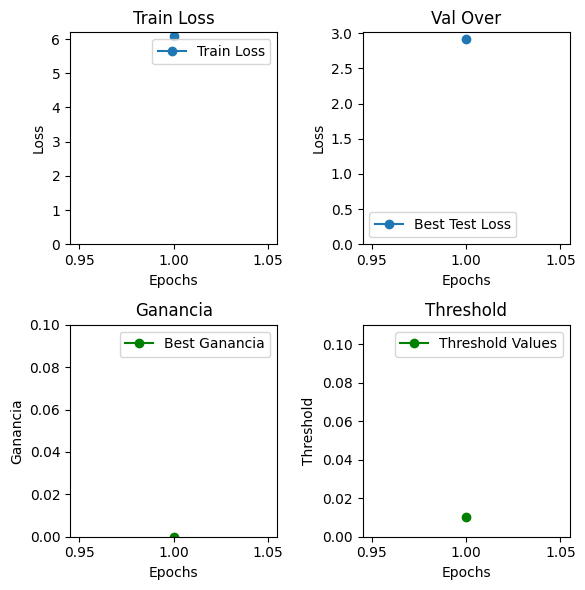

Epoch 2/300: 100%|███████████████████████████| 92/92 [01:01<00:00,  1.50it/s, Train Loss=1.97, CE Loss=2.06, Custom Loss=0.338, Weight=0.659, T=0.189]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.00      0.00      0.00      1248
    CONTINUA       0.88      1.00      0.94    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.88    183715
   macro avg       0.22      0.25      0.23    183715
weighted avg       0.78      0.88      0.83    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 0
CONTINUA: 183715
OUT: 0
Saving model with best validation loss: 1.3435

Epoch [2/300], Train Loss: 1.9676, Val Loss: 1.3435, Ganancia: 0, Threshold: 0.01, LR: 5e-06


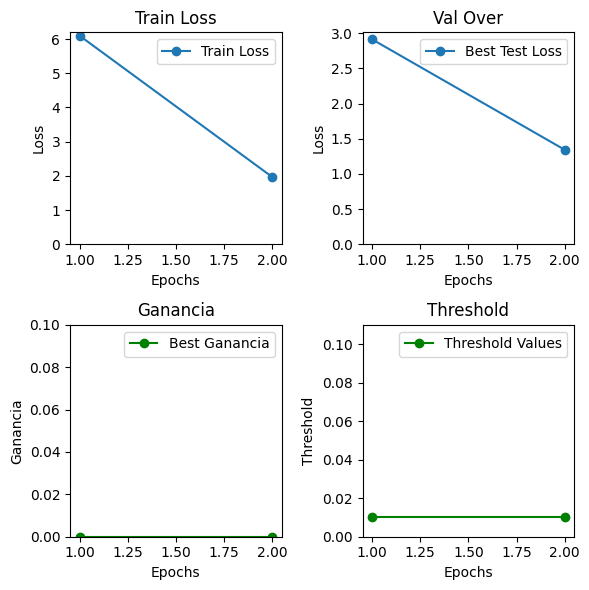

Epoch 3/300: 100%|███████████████████████████| 92/92 [01:01<00:00,  1.50it/s, Train Loss=1.07, CE Loss=2.28, Custom Loss=0.213, Weight=0.592, T=0.242]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.00      0.00      0.00      1248
    CONTINUA       0.88      1.00      0.94    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.88    183715
   macro avg       0.22      0.25      0.23    183715
weighted avg       0.78      0.88      0.83    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 0
CONTINUA: 183715
OUT: 0
Saving model with best validation loss: 0.8366

Epoch [3/300], Train Loss: 1.0731, Val Loss: 0.8366, Ganancia: 0, Threshold: 0.01, LR: 5e-06


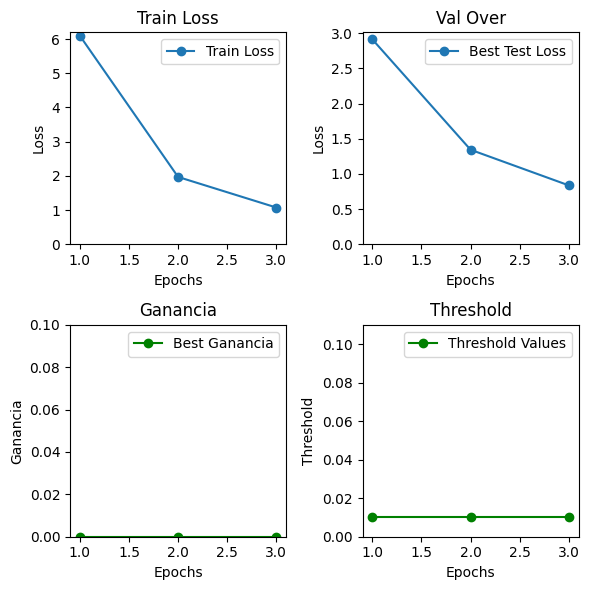

Epoch 4/300: 100%|██████████████████████████| 92/92 [01:01<00:00,  1.50it/s, Train Loss=0.699, CE Loss=2.48, Custom Loss=0.144, Weight=0.558, T=0.283]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.00      0.00      0.00      1248
    CONTINUA       0.88      1.00      0.94    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.88    183715
   macro avg       0.22      0.25      0.23    183715
weighted avg       0.78      0.88      0.83    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 0
CONTINUA: 183715
OUT: 0
Saving model with best validation loss: 0.5713

Epoch [4/300], Train Loss: 0.6989, Val Loss: 0.5713, Ganancia: 0, Threshold: 0.01, LR: 5e-06


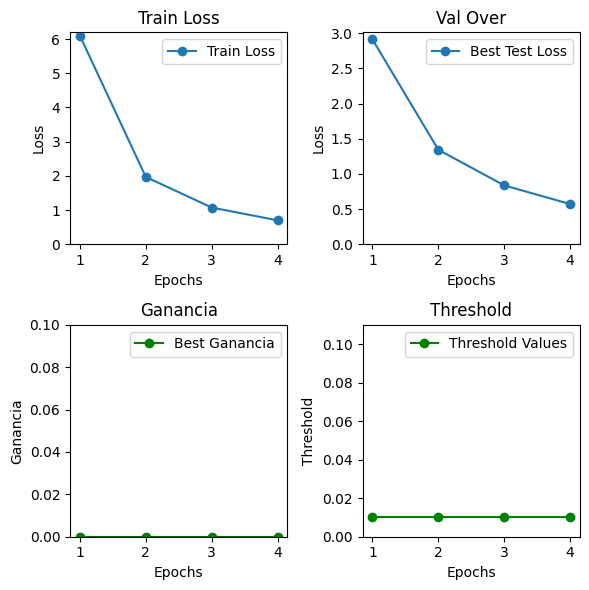

Epoch 5/300: 100%|██████████████████████████| 92/92 [01:01<00:00,  1.50it/s, Train Loss=0.493, CE Loss=2.43, Custom Loss=0.106, Weight=0.544, T=0.316]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.00      0.00      0.00      1248
    CONTINUA       0.88      1.00      0.94    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.88    183715
   macro avg       0.22      0.25      0.23    183715
weighted avg       0.78      0.88      0.83    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 0
CONTINUA: 183715
OUT: 0
Saving model with best validation loss: 0.4165

Epoch [5/300], Train Loss: 0.4928, Val Loss: 0.4165, Ganancia: 0, Threshold: 0.01, LR: 5e-06


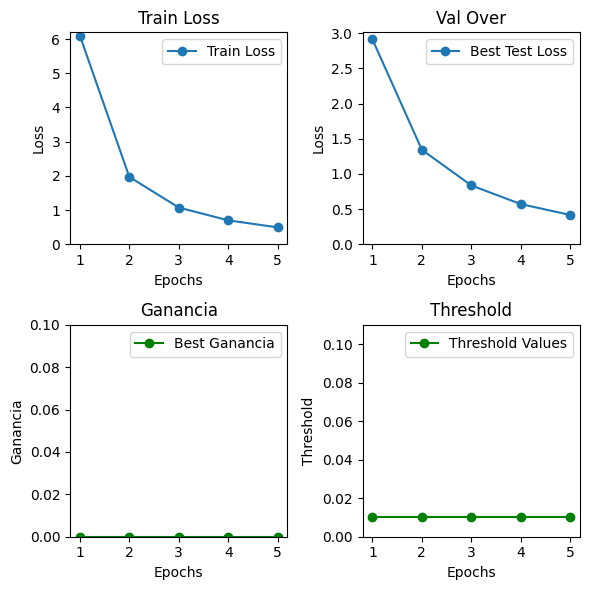

Epoch 6/300: 100%|█████████████████████████| 92/92 [01:01<00:00,  1.50it/s, Train Loss=0.368, CE Loss=2.42, Custom Loss=0.0807, Weight=0.533, T=0.345]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.00      0.00      0.00      1248
    CONTINUA       0.88      1.00      0.94    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.88    183715
   macro avg       0.22      0.25      0.23    183715
weighted avg       0.78      0.88      0.83    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 0
CONTINUA: 183715
OUT: 0
Saving model with best validation loss: 0.3184

Epoch [6/300], Train Loss: 0.3677, Val Loss: 0.3184, Ganancia: 0, Threshold: 0.01, LR: 5e-06


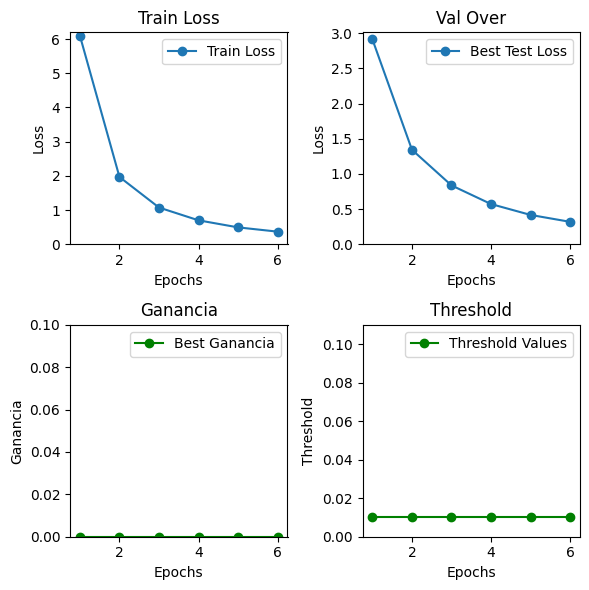

Epoch 7/300: 100%|█████████████████████████| 92/92 [01:01<00:00,  1.50it/s, Train Loss=0.286, CE Loss=2.48, Custom Loss=0.0629, Weight=0.525, T=0.369]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.00      0.00      0.00      1248
    CONTINUA       0.88      1.00      0.94    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.88    183715
   macro avg       0.22      0.25      0.23    183715
weighted avg       0.78      0.88      0.83    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 0
CONTINUA: 183715
OUT: 0
Saving model with best validation loss: 0.2521

Epoch [7/300], Train Loss: 0.2860, Val Loss: 0.2521, Ganancia: 0, Threshold: 0.01, LR: 5e-06


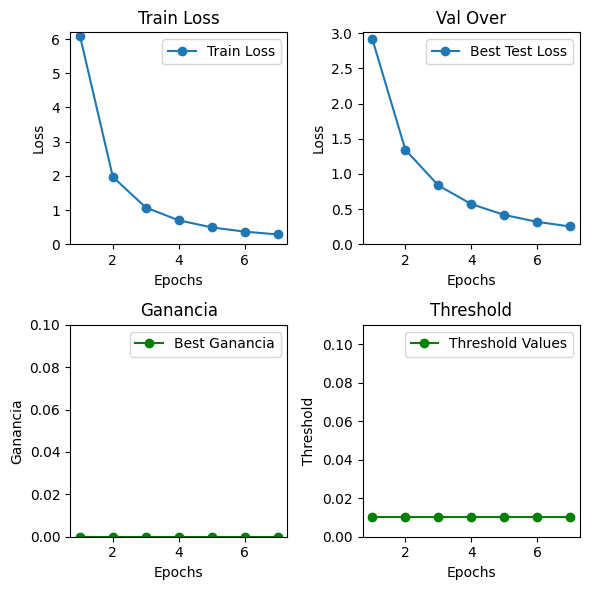

Epoch 8/300: 100%|███████████████████████████| 92/92 [01:01<00:00,  1.50it/s, Train Loss=0.23, CE Loss=2.32, Custom Loss=0.0521, Weight=0.522, T=0.39]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.00      0.00      0.00      1248
    CONTINUA       0.88      1.00      0.94    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.88    183715
   macro avg       0.22      0.25      0.23    183715
weighted avg       0.78      0.88      0.83    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 0
CONTINUA: 183715
OUT: 0
Saving model with best validation loss: 0.2051

Epoch [8/300], Train Loss: 0.2296, Val Loss: 0.2051, Ganancia: 0, Threshold: 0.01, LR: 5e-06


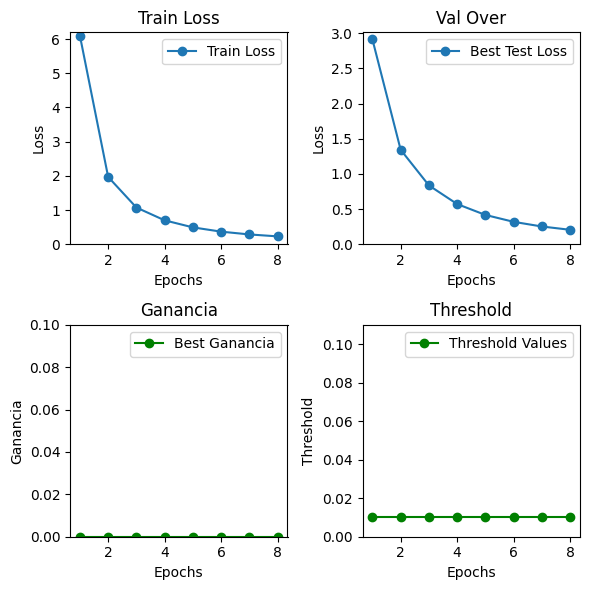

Epoch 9/300: 100%|█████████████████████████| 92/92 [01:01<00:00,  1.50it/s, Train Loss=0.189, CE Loss=2.33, Custom Loss=0.0427, Weight=0.518, T=0.409]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.00      0.00      0.00      1248
    CONTINUA       0.88      1.00      0.94    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.88    183715
   macro avg       0.22      0.25      0.23    183715
weighted avg       0.78      0.88      0.83    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 0
CONTINUA: 183715
OUT: 0
Saving model with best validation loss: 0.1705

Epoch [9/300], Train Loss: 0.1887, Val Loss: 0.1705, Ganancia: 0, Threshold: 0.01, LR: 5e-06


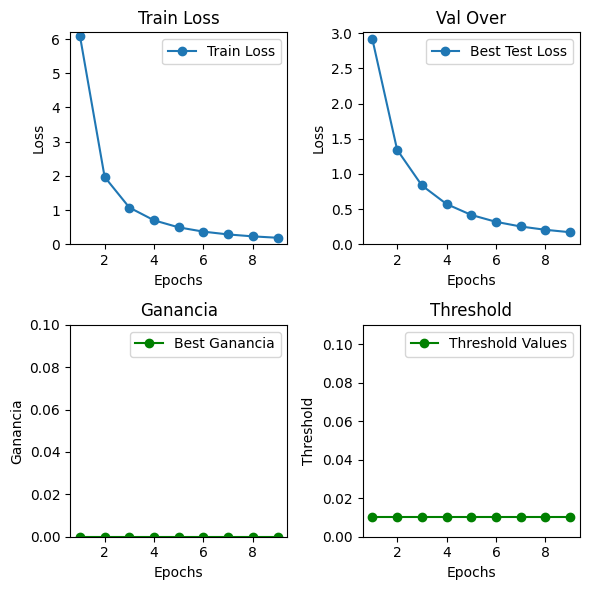

Epoch 10/300: 100%|██████████████████████████| 92/92 [01:01<00:00,  1.49it/s, Train Loss=0.158, CE Loss=2.3, Custom Loss=0.036, Weight=0.516, T=0.426]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.00      0.00      0.00      1248
    CONTINUA       0.88      1.00      0.94    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.88    183715
   macro avg       0.22      0.25      0.23    183715
weighted avg       0.78      0.88      0.83    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 0
CONTINUA: 183715
OUT: 0
Saving model with best validation loss: 0.1442

Epoch [10/300], Train Loss: 0.1582, Val Loss: 0.1442, Ganancia: 0, Threshold: 0.01, LR: 5e-06


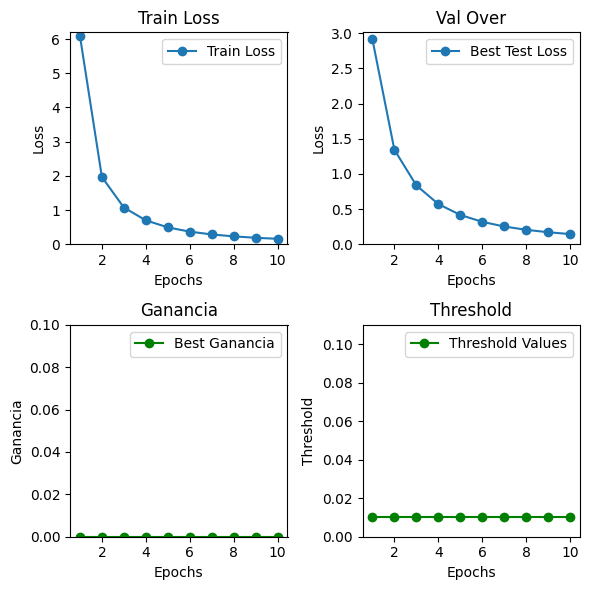

Epoch 11/300: 100%|█████████████████████████| 92/92 [01:01<00:00,  1.50it/s, Train Loss=0.135, CE Loss=2.2, Custom Loss=0.0311, Weight=0.514, T=0.442]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.00      0.00      0.00      1248
    CONTINUA       0.88      1.00      0.94    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.88    183715
   macro avg       0.22      0.25      0.23    183715
weighted avg       0.78      0.88      0.83    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 0
CONTINUA: 183715
OUT: 0
Saving model with best validation loss: 0.1237

Epoch [11/300], Train Loss: 0.1347, Val Loss: 0.1237, Ganancia: 0, Threshold: 0.01, LR: 5e-06


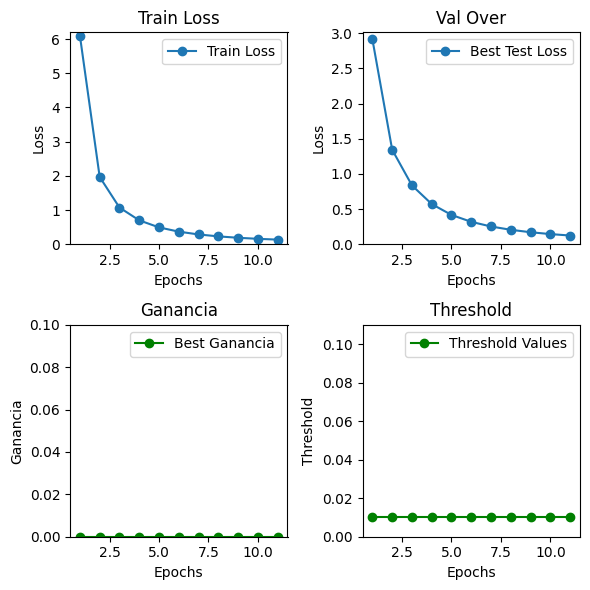

Epoch 12/300: 100%|████████████████████████| 92/92 [01:01<00:00,  1.50it/s, Train Loss=0.116, CE Loss=2.37, Custom Loss=0.0262, Weight=0.511, T=0.457]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.00      0.00      0.00      1248
    CONTINUA       0.88      1.00      0.94    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.88    183715
   macro avg       0.22      0.25      0.23    183715
weighted avg       0.78      0.88      0.83    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 0
CONTINUA: 183715
OUT: 0
Saving model with best validation loss: 0.1073

Epoch [12/300], Train Loss: 0.1162, Val Loss: 0.1073, Ganancia: 0, Threshold: 0.01, LR: 5e-06


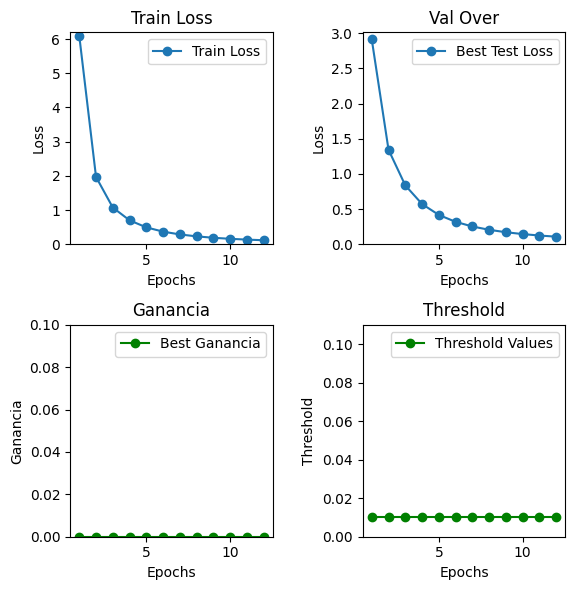

Epoch 13/300: 100%|████████████████████████| 92/92 [01:01<00:00,  1.50it/s, Train Loss=0.101, CE Loss=2.16, Custom Loss=0.0235, Weight=0.511, T=0.471]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.00      0.00      0.00      1248
    CONTINUA       0.88      1.00      0.94    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.88    183715
   macro avg       0.22      0.25      0.23    183715
weighted avg       0.78      0.88      0.83    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 0
CONTINUA: 183715
OUT: 0
Saving model with best validation loss: 0.0941

Epoch [13/300], Train Loss: 0.1014, Val Loss: 0.0941, Ganancia: 0, Threshold: 0.01, LR: 5e-06


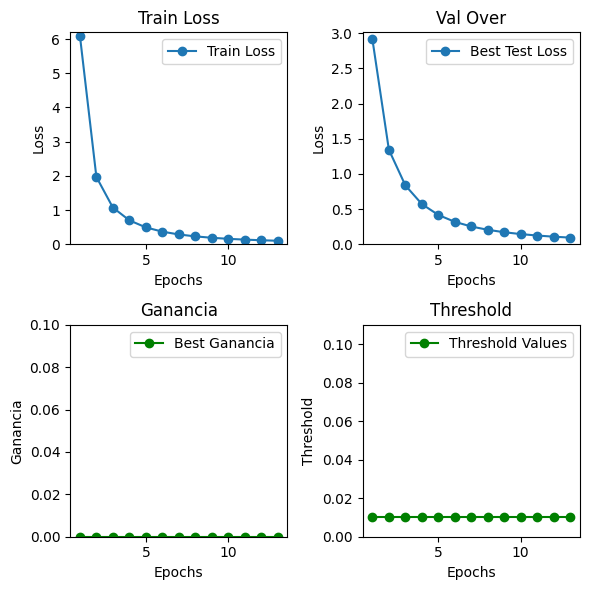

Epoch 14/300: 100%|███████████████████████| 92/92 [01:01<00:00,  1.49it/s, Train Loss=0.0892, CE Loss=2.24, Custom Loss=0.0204, Weight=0.509, T=0.483]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.00      0.00      0.00      1248
    CONTINUA       0.88      1.00      0.94    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.88    183715
   macro avg       0.22      0.25      0.23    183715
weighted avg       0.78      0.88      0.83    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 0
CONTINUA: 183715
OUT: 0
Saving model with best validation loss: 0.0832

Epoch [14/300], Train Loss: 0.0892, Val Loss: 0.0832, Ganancia: 0, Threshold: 0.01, LR: 5e-06


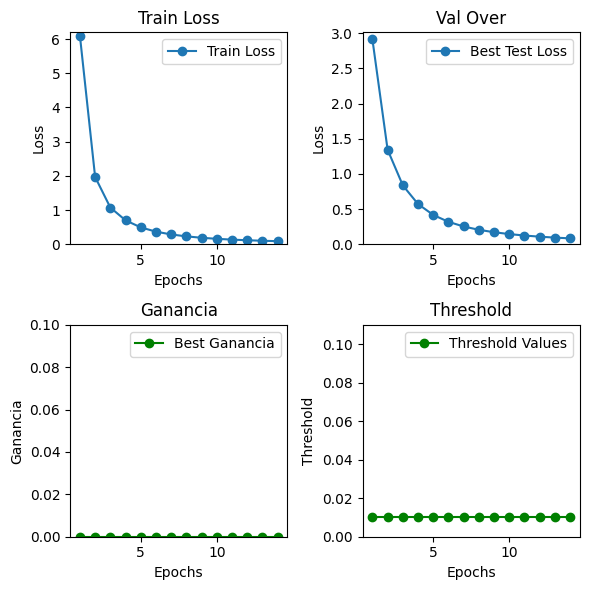

Epoch 15/300: 100%|████████████████████████| 92/92 [01:01<00:00,  1.49it/s, Train Loss=0.0792, CE Loss=2.25, Custom Loss=0.018, Weight=0.508, T=0.495]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.00      0.00      0.00      1248
    CONTINUA       0.88      1.00      0.94    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.88    183715
   macro avg       0.22      0.25      0.23    183715
weighted avg       0.78      0.88      0.83    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 0
CONTINUA: 183715
OUT: 0
Saving model with best validation loss: 0.0741

Epoch [15/300], Train Loss: 0.0792, Val Loss: 0.0741, Ganancia: 0, Threshold: 0.01, LR: 5e-06


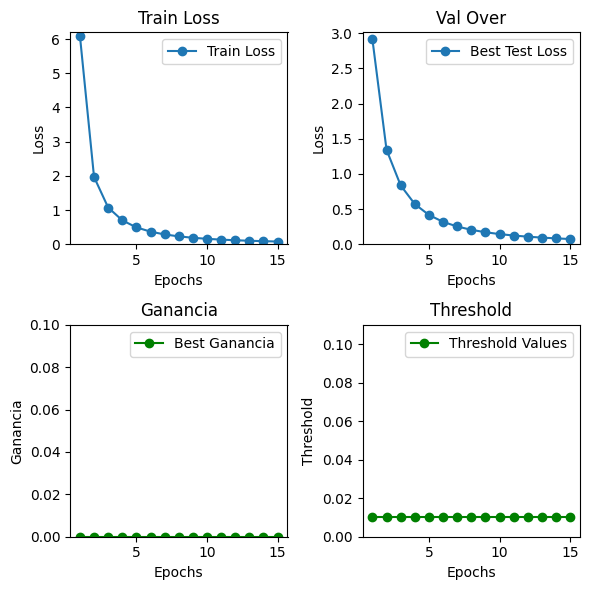

Epoch 16/300: 100%|███████████████████████| 92/92 [01:01<00:00,  1.49it/s, Train Loss=0.0707, CE Loss=2.06, Custom Loss=0.0165, Weight=0.508, T=0.507]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.00      0.00      0.00      1248
    CONTINUA       0.88      1.00      0.94    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.88    183715
   macro avg       0.22      0.25      0.23    183715
weighted avg       0.78      0.88      0.83    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 0
CONTINUA: 183715
OUT: 0
Saving model with best validation loss: 0.0664

Epoch [16/300], Train Loss: 0.0707, Val Loss: 0.0664, Ganancia: 0, Threshold: 0.01, LR: 5e-06


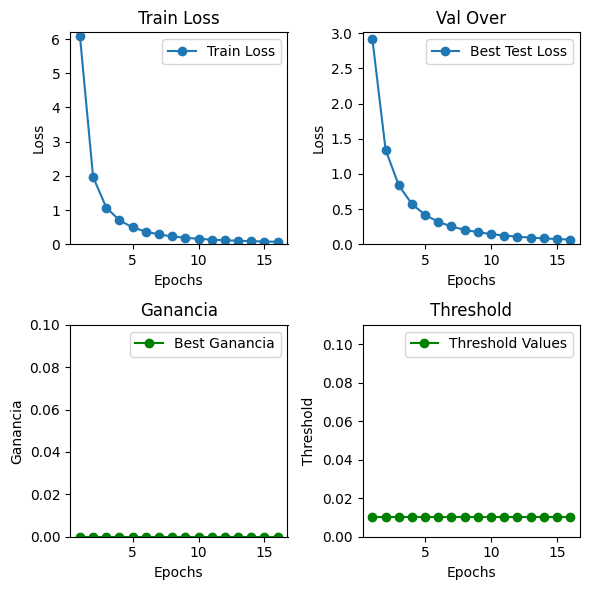

Epoch 17/300: 100%|███████████████████████| 92/92 [01:01<00:00,  1.50it/s, Train Loss=0.0636, CE Loss=2.09, Custom Loss=0.0147, Weight=0.507, T=0.518]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.00      0.00      0.00      1248
    CONTINUA       0.88      1.00      0.94    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.88    183715
   macro avg       0.22      0.25      0.23    183715
weighted avg       0.78      0.88      0.83    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 0
CONTINUA: 183715
OUT: 0
Saving model with best validation loss: 0.0598

Epoch [17/300], Train Loss: 0.0636, Val Loss: 0.0598, Ganancia: 0, Threshold: 0.01, LR: 5e-06


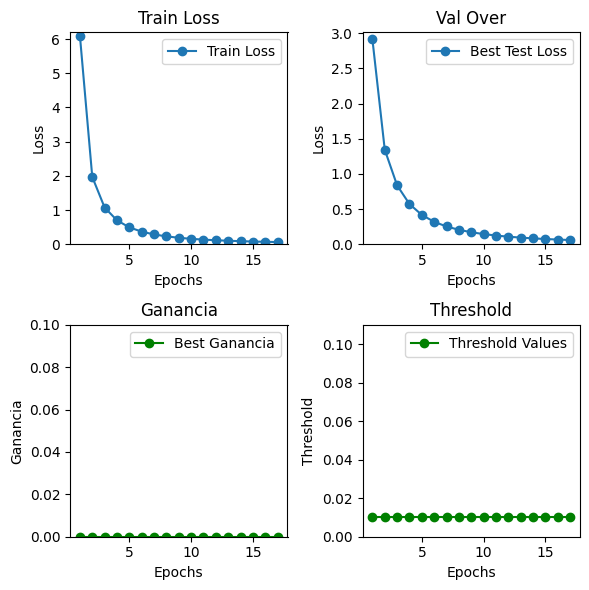

Epoch 18/300: 100%|███████████████████████| 92/92 [01:01<00:00,  1.50it/s, Train Loss=0.0574, CE Loss=2.04, Custom Loss=0.0133, Weight=0.507, T=0.528]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.00      0.00      0.00      1248
    CONTINUA       0.88      1.00      0.94    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.88    183715
   macro avg       0.22      0.25      0.23    183715
weighted avg       0.78      0.88      0.83    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 0
CONTINUA: 183715
OUT: 0
Saving model with best validation loss: 0.0542

Epoch [18/300], Train Loss: 0.0574, Val Loss: 0.0542, Ganancia: 0, Threshold: 0.01, LR: 5e-06


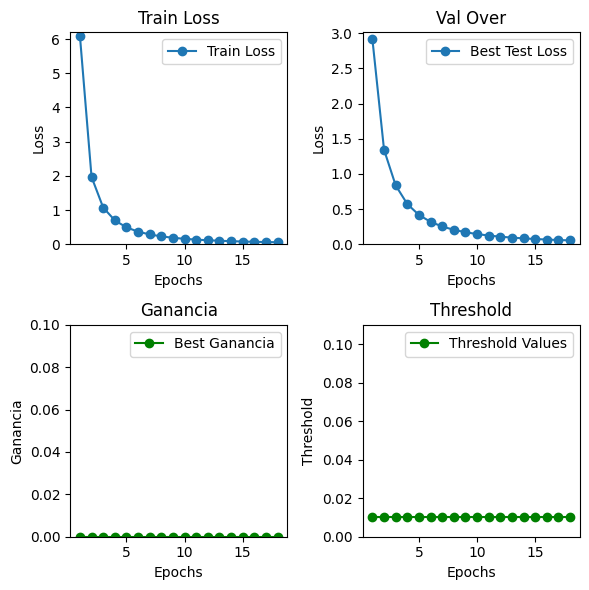

Epoch 19/300: 100%|███████████████████████| 92/92 [01:01<00:00,  1.50it/s, Train Loss=0.0521, CE Loss=2.15, Custom Loss=0.0118, Weight=0.505, T=0.538]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.00      0.00      0.00      1248
    CONTINUA       0.88      1.00      0.94    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.88    183715
   macro avg       0.22      0.25      0.23    183715
weighted avg       0.78      0.88      0.83    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 0
CONTINUA: 183715
OUT: 0
Saving model with best validation loss: 0.0493

Epoch [19/300], Train Loss: 0.0521, Val Loss: 0.0493, Ganancia: 0, Threshold: 0.01, LR: 5e-06


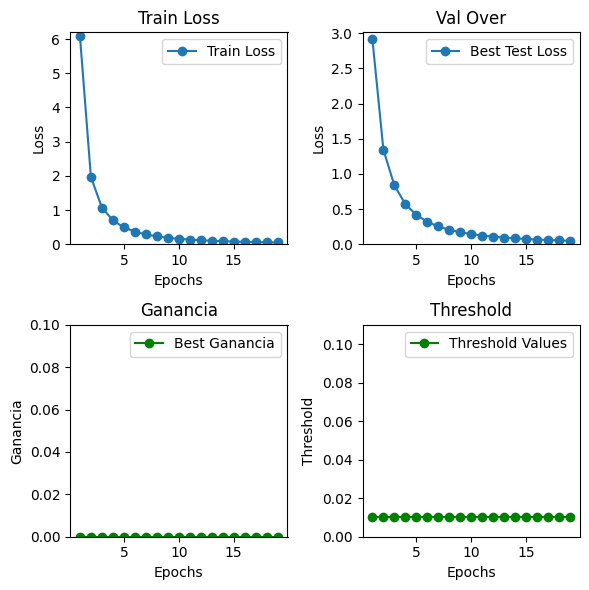

Epoch 20/300: 100%|███████████████████████| 92/92 [01:01<00:00,  1.49it/s, Train Loss=0.0475, CE Loss=2.04, Custom Loss=0.0108, Weight=0.505, T=0.547]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.00      0.00      0.00      1248
    CONTINUA       0.88      1.00      0.94    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.88    183715
   macro avg       0.22      0.25      0.23    183715
weighted avg       0.78      0.88      0.83    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 0
CONTINUA: 183715
OUT: 0
Saving model with best validation loss: 0.0450

Epoch [20/300], Train Loss: 0.0475, Val Loss: 0.0450, Ganancia: 0, Threshold: 0.01, LR: 5e-06


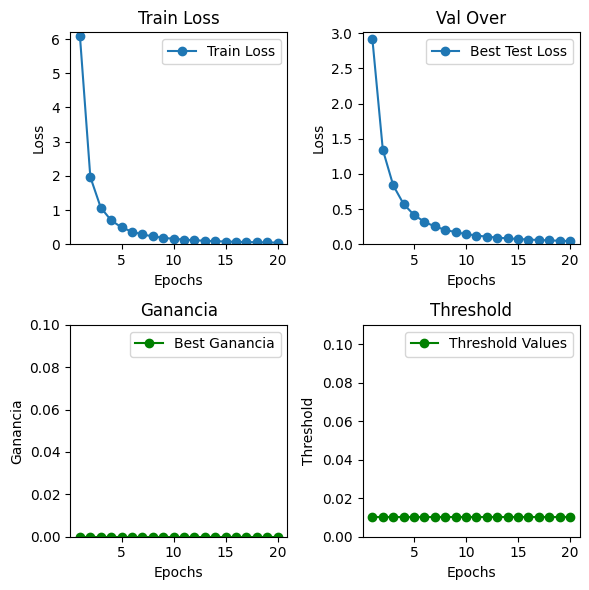

Epoch 21/300: 100%|██████████████████████| 92/92 [01:01<00:00,  1.50it/s, Train Loss=0.0434, CE Loss=2.03, Custom Loss=0.00975, Weight=0.505, T=0.556]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.00      0.00      0.00      1248
    CONTINUA       0.88      1.00      0.94    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.88    183715
   macro avg       0.22      0.25      0.23    183715
weighted avg       0.78      0.88      0.83    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 0
CONTINUA: 183715
OUT: 0
Saving model with best validation loss: 0.0412

Epoch [21/300], Train Loss: 0.0434, Val Loss: 0.0412, Ganancia: 0, Threshold: 0.01, LR: 5e-06


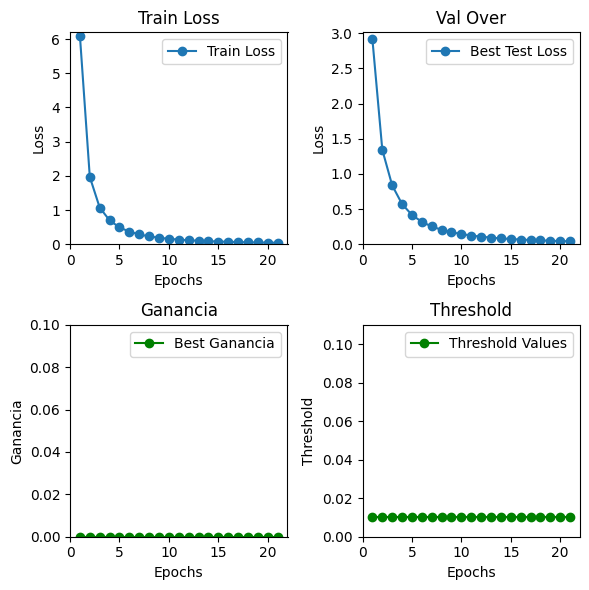

Epoch 22/300: 100%|██████████████████████| 92/92 [01:01<00:00,  1.49it/s, Train Loss=0.0398, CE Loss=1.88, Custom Loss=0.00885, Weight=0.505, T=0.565]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.14      0.01      0.02      1137
      BAJA+2       0.00      0.00      0.00      1248
    CONTINUA       0.88      1.00      0.94    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.88    183715
   macro avg       0.26      0.25      0.24    183715
weighted avg       0.78      0.88      0.83    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 78
BAJA+2: 0
CONTINUA: 183637
OUT: 0
Saving model with best validation loss: 0.0377

Epoch [22/300], Train Loss: 0.0398, Val Loss: 0.0377, Ganancia: 0, Threshold: 0.01, LR: 5e-06


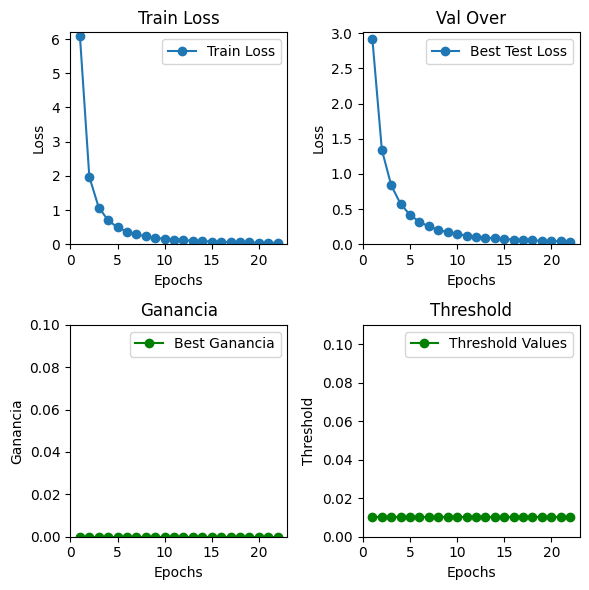

Epoch 23/300: 100%|██████████████████████| 92/92 [01:01<00:00,  1.50it/s, Train Loss=0.0363, CE Loss=1.44, Custom Loss=0.00888, Weight=0.506, T=0.574]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.08      0.34      0.13      1248
    CONTINUA       0.88      0.97      0.93    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.86    183715
   macro avg       0.24      0.33      0.26    183715
weighted avg       0.78      0.86      0.82    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 56
BAJA+2: 5243
CONTINUA: 178416
OUT: 0
Saving model with best validation loss: 0.0357
Saving model with best ganancia: 34911

Epoch [23/300], Train Loss: 0.0363, Val Loss: 0.0357, Ganancia: 34911, Threshold: 0.06, LR: 5e-06


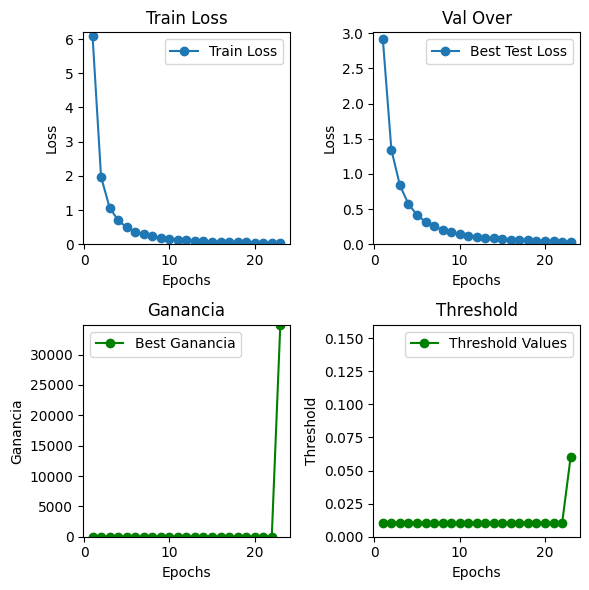

Epoch 24/300: 100%|██████████████████████| 92/92 [01:02<00:00,  1.47it/s, Train Loss=0.0344, CE Loss=1.44, Custom Loss=0.00797, Weight=0.506, T=0.582]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.09      0.35      0.15      1248
    CONTINUA       0.88      0.98      0.93    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.86    183715
   macro avg       0.24      0.33      0.27    183715
weighted avg       0.78      0.86      0.82    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 1
BAJA+2: 4795
CONTINUA: 178919
OUT: 0
Saving model with best validation loss: 0.0329
Saving model with best ganancia: 38655

Epoch [24/300], Train Loss: 0.0344, Val Loss: 0.0329, Ganancia: 38655, Threshold: 0.01, LR: 5e-06


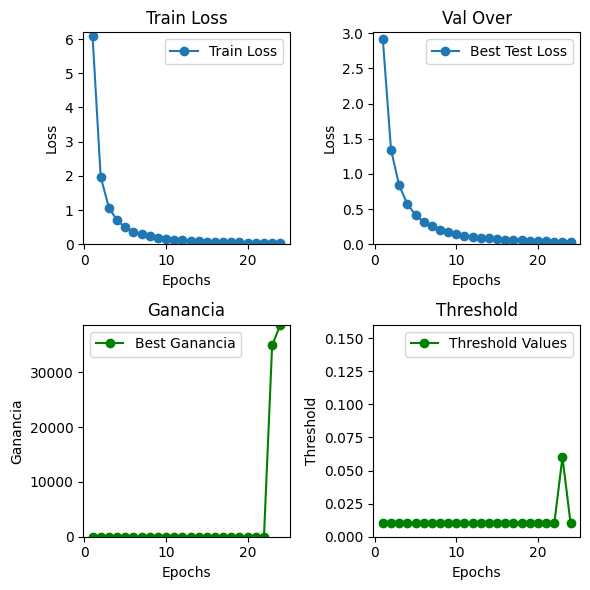

Epoch 25/300: 100%|███████████████████████| 92/92 [01:02<00:00,  1.47it/s, Train Loss=0.0318, CE Loss=1.32, Custom Loss=0.00737, Weight=0.506, T=0.59]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.08      0.40      0.14      1248
    CONTINUA       0.88      0.97      0.93    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.86    183715
   macro avg       0.24      0.34      0.27    183715
weighted avg       0.78      0.86      0.82    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 2
BAJA+2: 5887
CONTINUA: 177826
OUT: 0
Saving model with best validation loss: 0.0308
Saving model with best ganancia: 41979

Epoch [25/300], Train Loss: 0.0318, Val Loss: 0.0308, Ganancia: 41979, Threshold: 0.01, LR: 5e-06


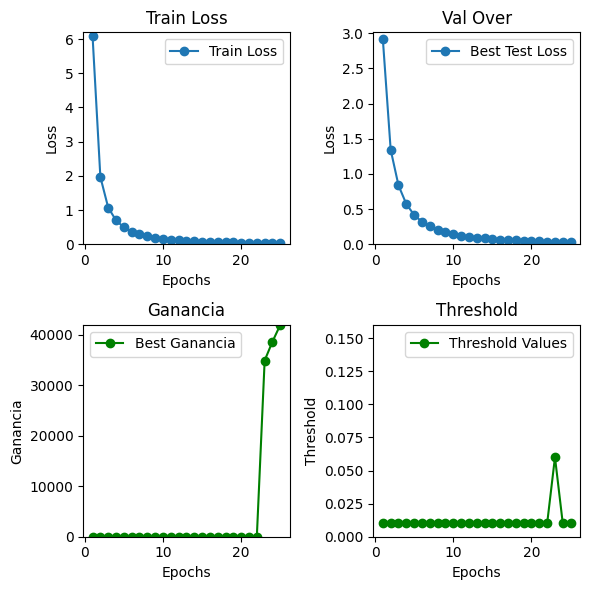

Epoch 26/300: 100%|███████████████████████| 92/92 [01:02<00:00,  1.47it/s, Train Loss=0.0295, CE Loss=1.4, Custom Loss=0.00678, Weight=0.505, T=0.598]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.09      0.36      0.15      1248
    CONTINUA       0.88      0.98      0.93    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.86    183715
   macro avg       0.24      0.33      0.27    183715
weighted avg       0.78      0.86      0.82    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 12
BAJA+2: 4898
CONTINUA: 178805
OUT: 0
Saving model with best validation loss: 0.0281

Epoch [26/300], Train Loss: 0.0295, Val Loss: 0.0281, Ganancia: 39186, Threshold: 0.04, LR: 5e-06


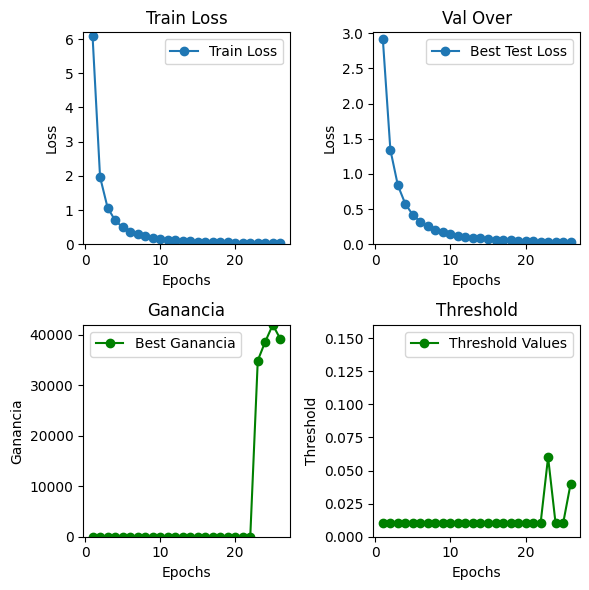

Epoch 27/300: 100%|██████████████████████| 92/92 [01:02<00:00,  1.47it/s, Train Loss=0.0274, CE Loss=1.43, Custom Loss=0.00604, Weight=0.504, T=0.606]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.10      0.00      0.00      1137
      BAJA+2       0.09      0.37      0.14      1248
    CONTINUA       0.88      0.97      0.93    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.86    183715
   macro avg       0.27      0.34      0.27    183715
weighted avg       0.78      0.86      0.82    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 10
BAJA+2: 5235
CONTINUA: 178470
OUT: 0
Saving model with best validation loss: 0.0261

Epoch [27/300], Train Loss: 0.0274, Val Loss: 0.0261, Ganancia: 40335, Threshold: 0.03, LR: 5e-06


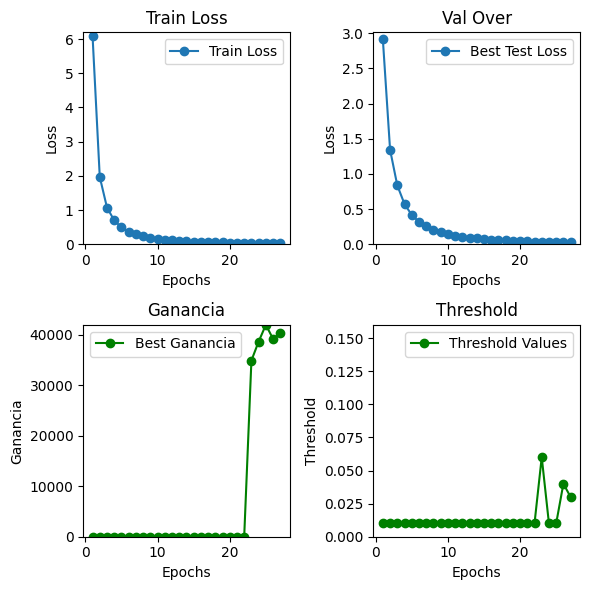

Epoch 28/300: 100%|███████████████████████| 92/92 [01:03<00:00,  1.45it/s, Train Loss=0.0254, CE Loss=1.4, Custom Loss=0.00582, Weight=0.504, T=0.614]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.08      0.41      0.14      1248
    CONTINUA       0.88      0.97      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.86    183715
   macro avg       0.24      0.34      0.27    183715
weighted avg       0.78      0.86      0.82    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 1
BAJA+2: 6169
CONTINUA: 177545
OUT: 0
Saving model with best validation loss: 0.0243
Saving model with best ganancia: 43053

Epoch [28/300], Train Loss: 0.0254, Val Loss: 0.0243, Ganancia: 43053, Threshold: 0.02, LR: 5e-06


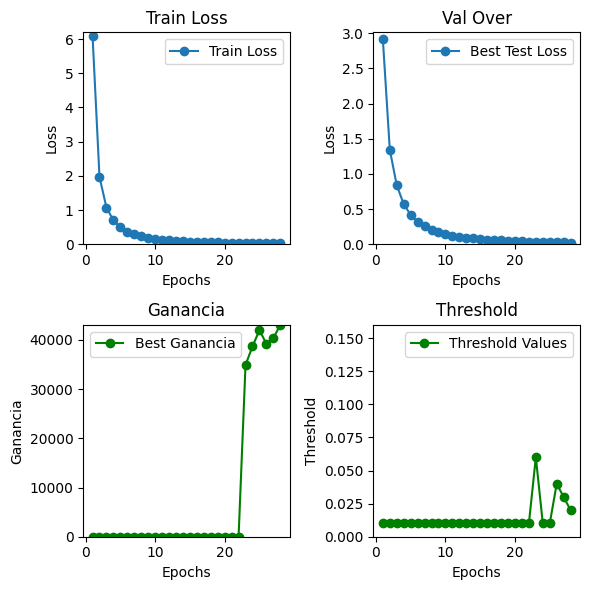

Epoch 29/300: 100%|██████████████████████| 92/92 [01:02<00:00,  1.46it/s, Train Loss=0.0238, CE Loss=1.38, Custom Loss=0.00525, Weight=0.504, T=0.621]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.50      0.00      0.00      1137
      BAJA+2       0.08      0.39      0.14      1248
    CONTINUA       0.88      0.97      0.93    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.86    183715
   macro avg       0.37      0.34      0.27    183715
weighted avg       0.78      0.86      0.82    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 2
BAJA+2: 5776
CONTINUA: 177937
OUT: 0
Saving model with best validation loss: 0.0228

Epoch [29/300], Train Loss: 0.0238, Val Loss: 0.0228, Ganancia: 41472, Threshold: 0.03, LR: 5e-06


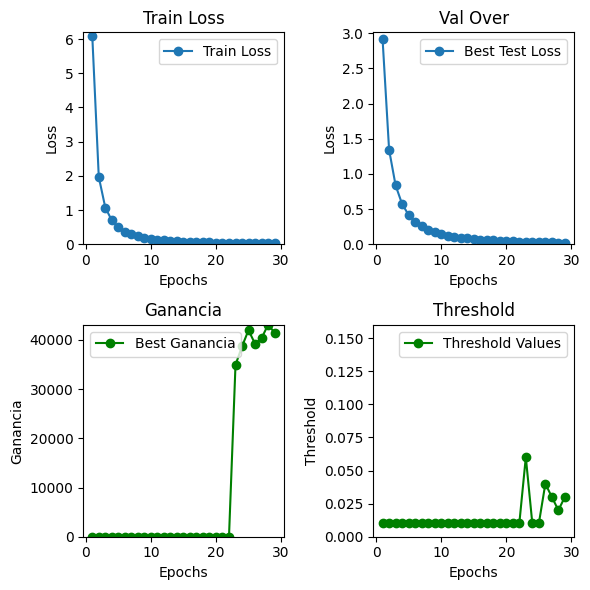

Epoch 30/300: 100%|██████████████████████| 92/92 [01:02<00:00,  1.47it/s, Train Loss=0.0221, CE Loss=1.23, Custom Loss=0.00512, Weight=0.504, T=0.629]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.08      0.43      0.13      1248
    CONTINUA       0.88      0.96      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.85    183715
   macro avg       0.24      0.35      0.26    183715
weighted avg       0.78      0.85      0.82    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 1
BAJA+2: 6865
CONTINUA: 176849
OUT: 0
Saving model with best validation loss: 0.0214
Saving model with best ganancia: 44325

Epoch [30/300], Train Loss: 0.0221, Val Loss: 0.0214, Ganancia: 44325, Threshold: 0.02, LR: 5e-06


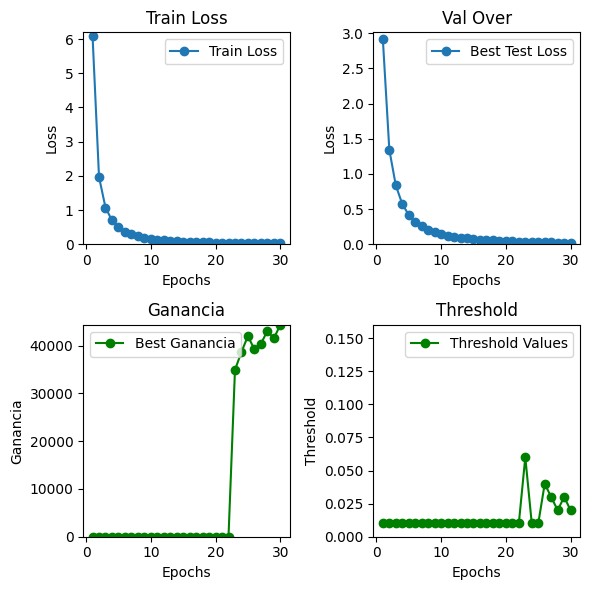

Epoch 31/300: 100%|██████████████████████| 92/92 [01:03<00:00,  1.44it/s, Train Loss=0.0207, CE Loss=1.26, Custom Loss=0.00466, Weight=0.504, T=0.636]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.04      0.00      0.00      1137
      BAJA+2       0.08      0.44      0.13      1248
    CONTINUA       0.88      0.96      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.85    183715
   macro avg       0.25      0.35      0.27    183715
weighted avg       0.78      0.85      0.82    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 54
BAJA+2: 6877
CONTINUA: 176784
OUT: 0
Saving model with best validation loss: 0.0202
Saving model with best ganancia: 44649

Epoch [31/300], Train Loss: 0.0207, Val Loss: 0.0202, Ganancia: 44649, Threshold: 0.21, LR: 5e-06


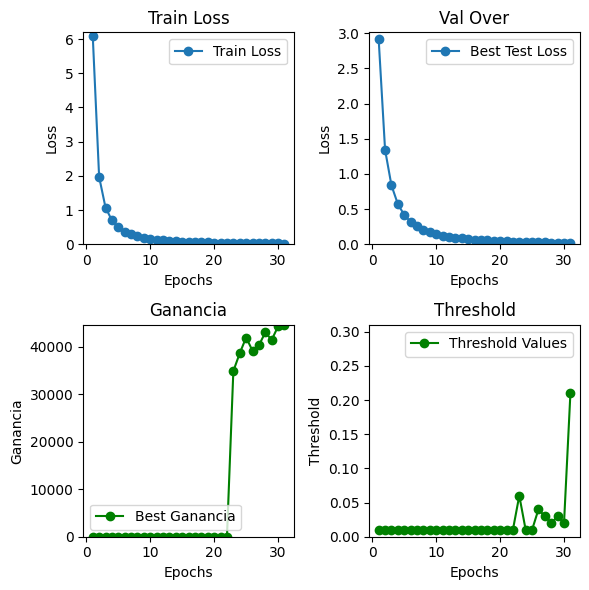

Epoch 32/300: 100%|██████████████████████| 92/92 [01:03<00:00,  1.46it/s, Train Loss=0.0194, CE Loss=1.38, Custom Loss=0.00432, Weight=0.503, T=0.643]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.08      0.41      0.14      1248
    CONTINUA       0.88      0.97      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.86    183715
   macro avg       0.24      0.35      0.27    183715
weighted avg       0.78      0.86      0.82    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 6278
CONTINUA: 177437
OUT: 0
Saving model with best validation loss: 0.0187

Epoch [32/300], Train Loss: 0.0194, Val Loss: 0.0187, Ganancia: 43086, Threshold: 0.02, LR: 5e-06


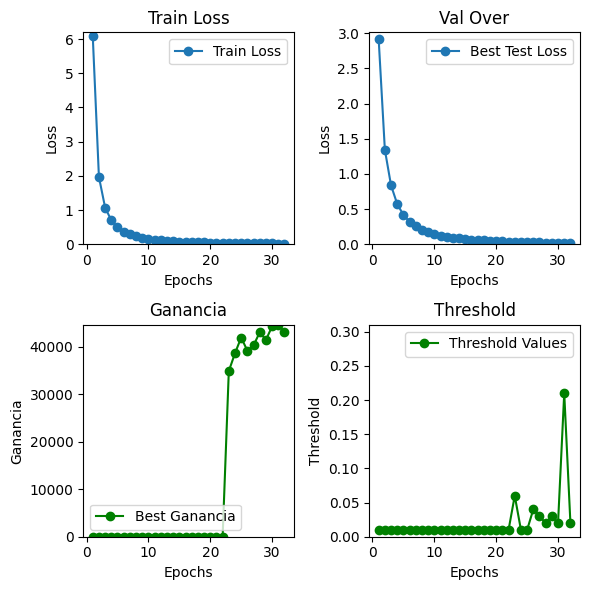

Epoch 33/300: 100%|██████████████████████| 92/92 [01:02<00:00,  1.47it/s, Train Loss=0.0182, CE Loss=1.35, Custom Loss=0.00407, Weight=0.503, T=0.649]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.08      0.42      0.14      1248
    CONTINUA       0.88      0.97      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.86    183715
   macro avg       0.24      0.35      0.26    183715
weighted avg       0.78      0.86      0.82    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 6440
CONTINUA: 177275
OUT: 0
Saving model with best validation loss: 0.0174

Epoch [33/300], Train Loss: 0.0182, Val Loss: 0.0174, Ganancia: 43320, Threshold: 0.02, LR: 5e-06


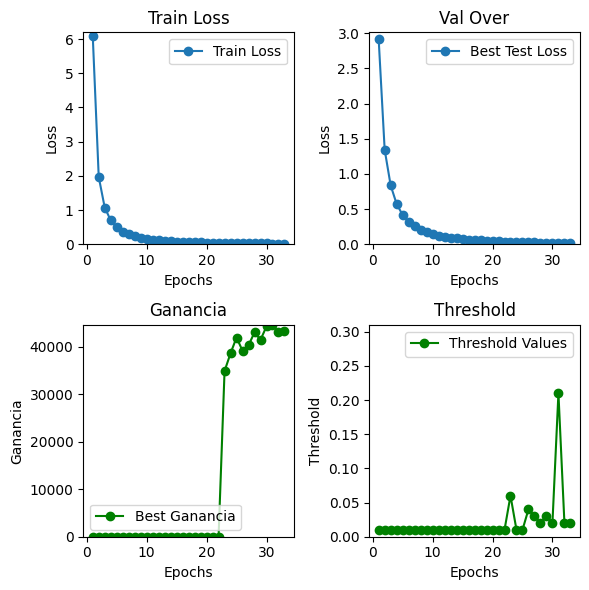

Epoch 34/300: 100%|███████████████████████| 92/92 [01:02<00:00,  1.48it/s, Train Loss=0.0171, CE Loss=1.3, Custom Loss=0.00368, Weight=0.503, T=0.656]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.08      0.41      0.14      1248
    CONTINUA       0.88      0.97      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.86    183715
   macro avg       0.24      0.35      0.27    183715
weighted avg       0.78      0.86      0.82    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 0
BAJA+2: 6238
CONTINUA: 177477
OUT: 0
Saving model with best validation loss: 0.0164

Epoch [34/300], Train Loss: 0.0171, Val Loss: 0.0164, Ganancia: 43086, Threshold: 0.01, LR: 5e-06


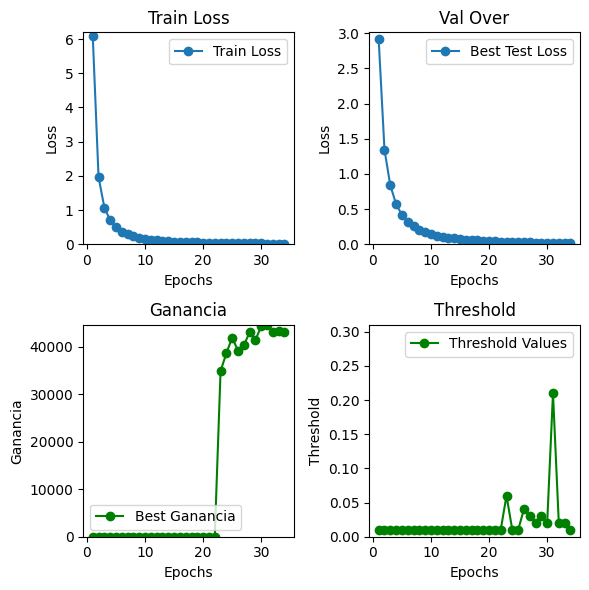

Epoch 35/300: 100%|██████████████████████| 92/92 [01:02<00:00,  1.48it/s, Train Loss=0.0161, CE Loss=1.38, Custom Loss=0.00354, Weight=0.503, T=0.663]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.05      0.00      0.00      1137
      BAJA+2       0.08      0.42      0.14      1248
    CONTINUA       0.88      0.97      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.86    183715
   macro avg       0.25      0.35      0.27    183715
weighted avg       0.78      0.86      0.82    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 21
BAJA+2: 6326
CONTINUA: 177368
OUT: 0
Saving model with best validation loss: 0.0154

Epoch [35/300], Train Loss: 0.0161, Val Loss: 0.0154, Ganancia: 43422, Threshold: 0.06, LR: 5e-06


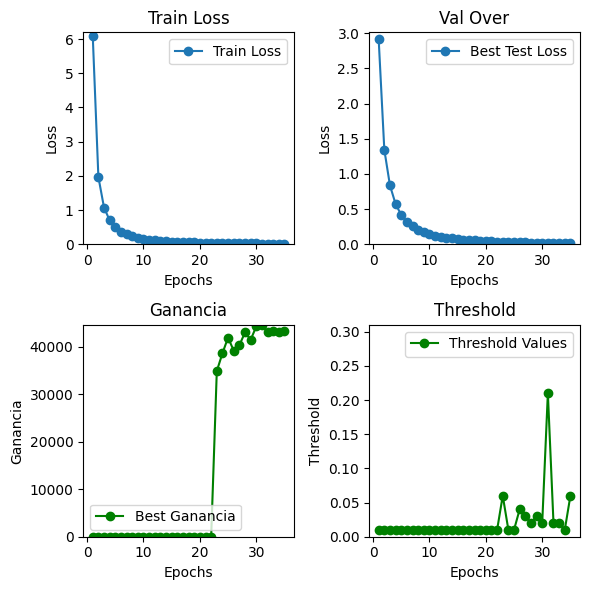

Epoch 36/300: 100%|██████████████████████| 92/92 [01:02<00:00,  1.48it/s, Train Loss=0.0152, CE Loss=1.25, Custom Loss=0.00355, Weight=0.503, T=0.669]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.08      0.45      0.13      1248
    CONTINUA       0.88      0.96      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.85    183715
   macro avg       0.24      0.35      0.26    183715
weighted avg       0.78      0.85      0.81    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 34
BAJA+2: 7459
CONTINUA: 176222
OUT: 0
Saving model with best validation loss: 0.0147
Saving model with best ganancia: 45423

Epoch [36/300], Train Loss: 0.0152, Val Loss: 0.0147, Ganancia: 45423, Threshold: 0.12, LR: 5e-06


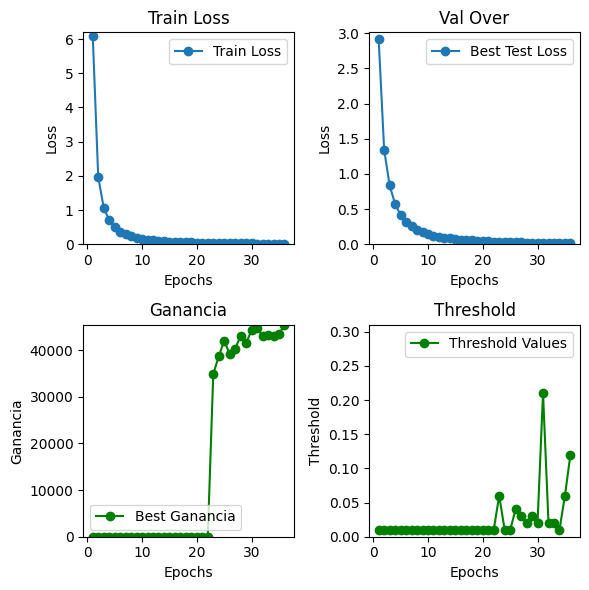

Epoch 37/300: 100%|███████████████████████| 92/92 [01:02<00:00,  1.47it/s, Train Loss=0.0143, CE Loss=1.2, Custom Loss=0.00318, Weight=0.503, T=0.675]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.07      0.46      0.13      1248
    CONTINUA       0.88      0.96      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.85    183715
   macro avg       0.24      0.36      0.26    183715
weighted avg       0.78      0.85      0.81    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 20
BAJA+2: 7820
CONTINUA: 175875
OUT: 0
Saving model with best validation loss: 0.0139
Saving model with best ganancia: 45780

Epoch [37/300], Train Loss: 0.0143, Val Loss: 0.0139, Ganancia: 45780, Threshold: 0.06, LR: 5e-06


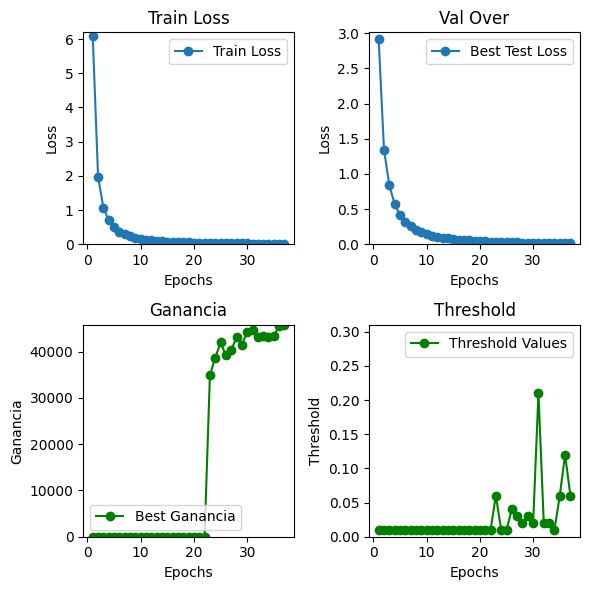

Epoch 38/300: 100%|██████████████████████| 92/92 [01:02<00:00,  1.48it/s, Train Loss=0.0135, CE Loss=1.34, Custom Loss=0.00288, Weight=0.502, T=0.682]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.21      0.00      0.01      1137
      BAJA+2       0.08      0.41      0.14      1248
    CONTINUA       0.88      0.97      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.86    183715
   macro avg       0.30      0.35      0.27    183715
weighted avg       0.78      0.86      0.82    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 14
BAJA+2: 6154
CONTINUA: 177547
OUT: 0
Saving model with best validation loss: 0.0129

Epoch [38/300], Train Loss: 0.0135, Val Loss: 0.0129, Ganancia: 42978, Threshold: 0.01, LR: 5e-06


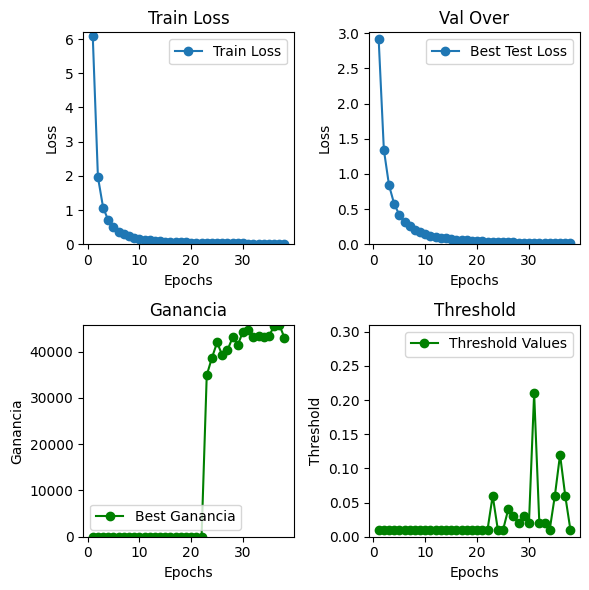

Epoch 39/300: 100%|███████████████████████| 92/92 [01:02<00:00,  1.46it/s, Train Loss=0.0128, CE Loss=1.21, Custom Loss=0.0028, Weight=0.502, T=0.688]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.08      0.46      0.13      1248
    CONTINUA       0.88      0.96      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.85    183715
   macro avg       0.24      0.35      0.26    183715
weighted avg       0.78      0.85      0.81    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 14
BAJA+2: 7441
CONTINUA: 176260
OUT: 0
Saving model with best validation loss: 0.0124
Saving model with best ganancia: 45957

Epoch [39/300], Train Loss: 0.0128, Val Loss: 0.0124, Ganancia: 45957, Threshold: 0.02, LR: 5e-06


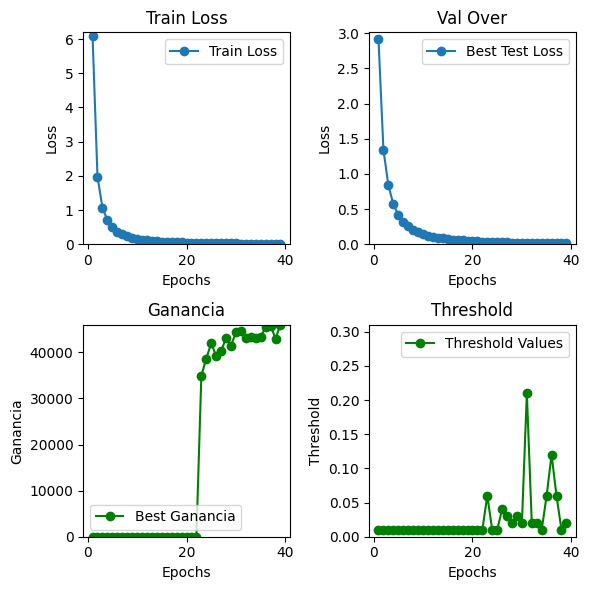

Epoch 40/300: 100%|██████████████████████| 92/92 [01:02<00:00,  1.47it/s, Train Loss=0.0121, CE Loss=1.21, Custom Loss=0.00264, Weight=0.502, T=0.694]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.02      0.00      0.00      1137
      BAJA+2       0.08      0.46      0.13      1248
    CONTINUA       0.88      0.96      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.85    183715
   macro avg       0.25      0.35      0.26    183715
weighted avg       0.78      0.85      0.81    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 47
BAJA+2: 7576
CONTINUA: 176092
OUT: 0
Saving model with best validation loss: 0.0116

Epoch [40/300], Train Loss: 0.0121, Val Loss: 0.0116, Ganancia: 45912, Threshold: 0.06, LR: 5e-06


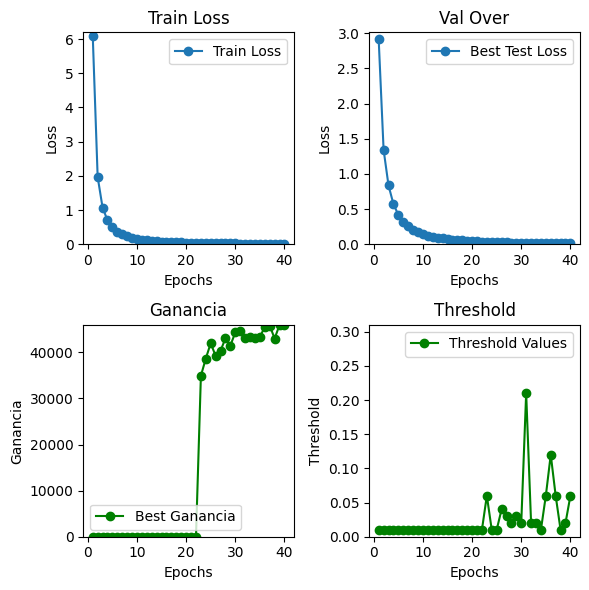

Epoch 41/300: 100%|████████████████████████| 92/92 [01:02<00:00,  1.48it/s, Train Loss=0.0114, CE Loss=1.13, Custom Loss=0.00244, Weight=0.502, T=0.7]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.07      0.47      0.13      1248
    CONTINUA       0.88      0.96      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.85    183715
   macro avg       0.24      0.36      0.26    183715
weighted avg       0.78      0.85      0.81    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 42
BAJA+2: 8137
CONTINUA: 175536
OUT: 0
Saving model with best validation loss: 0.0111
Saving model with best ganancia: 46389

Epoch [41/300], Train Loss: 0.0114, Val Loss: 0.0111, Ganancia: 46389, Threshold: 0.07, LR: 5e-06


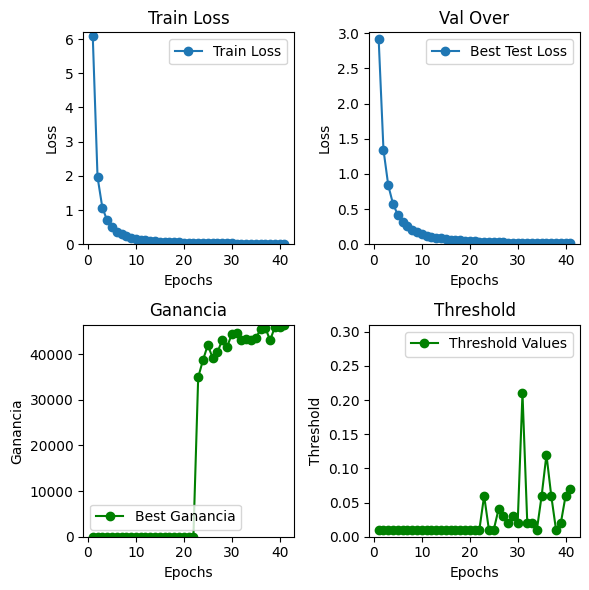

Epoch 42/300: 100%|███████████████████████| 92/92 [01:01<00:00,  1.49it/s, Train Loss=0.0108, CE Loss=1.16, Custom Loss=0.0023, Weight=0.502, T=0.706]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.07      0.47      0.13      1248
    CONTINUA       0.88      0.96      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.85    183715
   macro avg       0.24      0.36      0.26    183715
weighted avg       0.78      0.85      0.81    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 4
BAJA+2: 8046
CONTINUA: 175665
OUT: 0
Saving model with best validation loss: 0.0105
Saving model with best ganancia: 46422

Epoch [42/300], Train Loss: 0.0108, Val Loss: 0.0105, Ganancia: 46422, Threshold: 0.01, LR: 5e-06


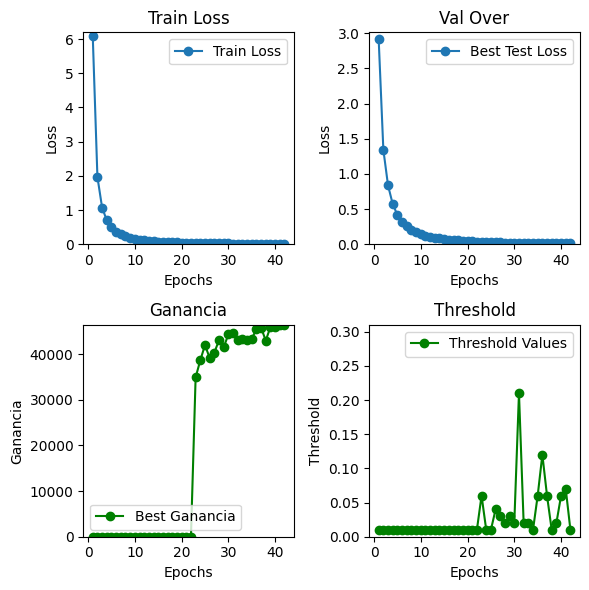

Epoch 43/300: 100%|██████████████████████| 92/92 [01:01<00:00,  1.49it/s, Train Loss=0.0103, CE Loss=1.26, Custom Loss=0.00222, Weight=0.502, T=0.712]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.18      0.00      0.01      1137
      BAJA+2       0.07      0.46      0.13      1248
    CONTINUA       0.88      0.96      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.85    183715
   macro avg       0.28      0.36      0.26    183715
weighted avg       0.78      0.85      0.81    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 17
BAJA+2: 7797
CONTINUA: 175901
OUT: 0
Saving model with best validation loss: 0.0099

Epoch [43/300], Train Loss: 0.0103, Val Loss: 0.0099, Ganancia: 46209, Threshold: 0.01, LR: 5e-06


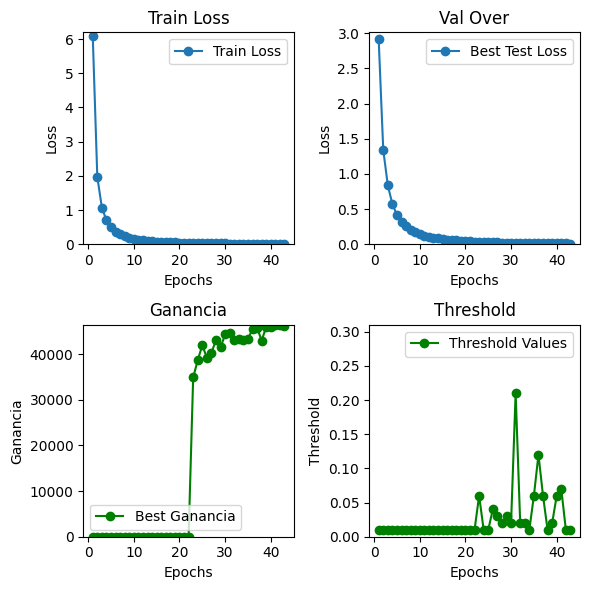

Epoch 44/300: 100%|█████████████████████| 92/92 [01:02<00:00,  1.47it/s, Train Loss=0.00976, CE Loss=1.21, Custom Loss=0.00194, Weight=0.502, T=0.718]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.07      0.48      0.12      1248
    CONTINUA       0.88      0.95      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.85    183715
   macro avg       0.24      0.36      0.26    183715
weighted avg       0.78      0.85      0.81    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 19
BAJA+2: 8704
CONTINUA: 174992
OUT: 0
Saving model with best validation loss: 0.0095
Saving model with best ganancia: 46488

Epoch [44/300], Train Loss: 0.0098, Val Loss: 0.0095, Ganancia: 46488, Threshold: 0.01, LR: 5e-06


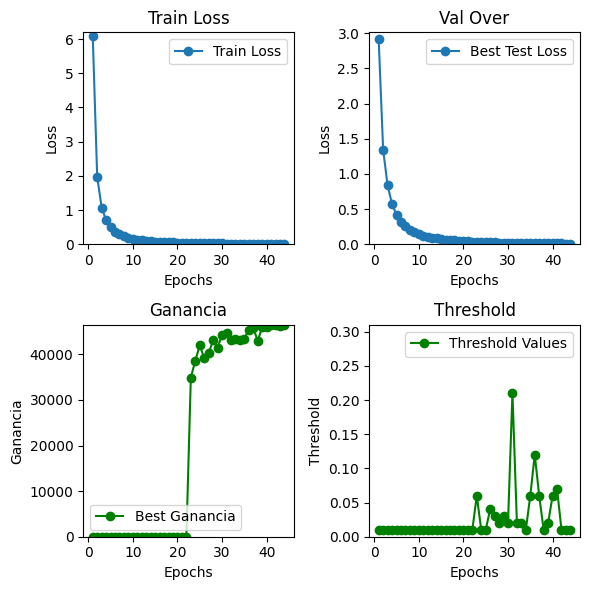

Epoch 45/300: 100%|█████████████████████| 92/92 [01:03<00:00,  1.45it/s, Train Loss=0.00929, CE Loss=1.19, Custom Loss=0.00196, Weight=0.502, T=0.723]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.07      0.50      0.12      1248
    CONTINUA       0.88      0.95      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.84    183715
   macro avg       0.24      0.36      0.26    183715
weighted avg       0.78      0.84      0.81    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 25
BAJA+2: 9247
CONTINUA: 174443
OUT: 0
Saving model with best validation loss: 0.0091
Saving model with best ganancia: 47019

Epoch [45/300], Train Loss: 0.0093, Val Loss: 0.0091, Ganancia: 47019, Threshold: 0.02, LR: 5e-06


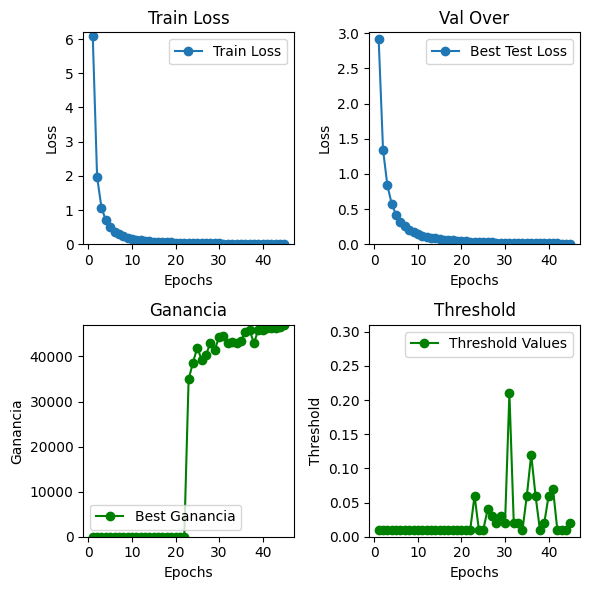

Epoch 46/300: 100%|█████████████████████| 92/92 [01:02<00:00,  1.46it/s, Train Loss=0.00885, CE Loss=1.12, Custom Loss=0.00192, Weight=0.502, T=0.729]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.05      0.00      0.00      1137
      BAJA+2       0.07      0.47      0.13      1248
    CONTINUA       0.88      0.96      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.85    183715
   macro avg       0.25      0.36      0.26    183715
weighted avg       0.78      0.85      0.81    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 40
BAJA+2: 8149
CONTINUA: 175526
OUT: 0
Saving model with best validation loss: 0.0086

Epoch [46/300], Train Loss: 0.0089, Val Loss: 0.0086, Ganancia: 46473, Threshold: 0.07, LR: 5e-06


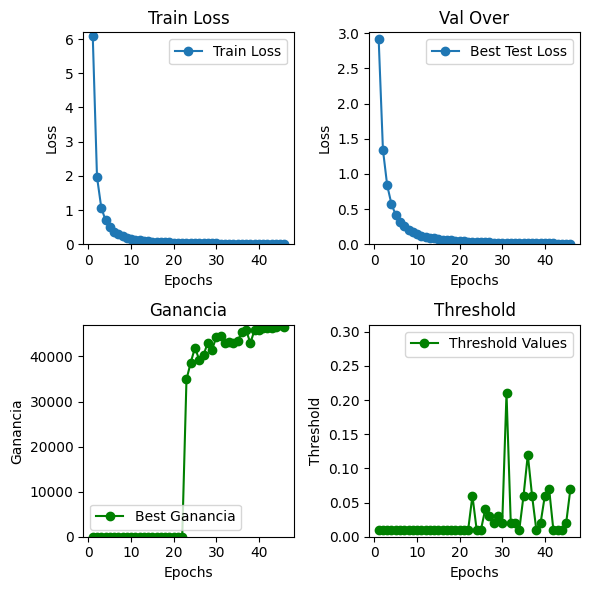

Epoch 47/300: 100%|██████████████████████| 92/92 [01:02<00:00,  1.46it/s, Train Loss=0.0084, CE Loss=1.18, Custom Loss=0.00186, Weight=0.502, T=0.735]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.00      0.00      0.00      1137
      BAJA+2       0.07      0.49      0.12      1248
    CONTINUA       0.88      0.95      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.85    183715
   macro avg       0.24      0.36      0.26    183715
weighted avg       0.78      0.85      0.81    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 5
BAJA+2: 8804
CONTINUA: 174906
OUT: 0
Saving model with best validation loss: 0.0082

Epoch [47/300], Train Loss: 0.0084, Val Loss: 0.0082, Ganancia: 46548, Threshold: 0.01, LR: 5e-06


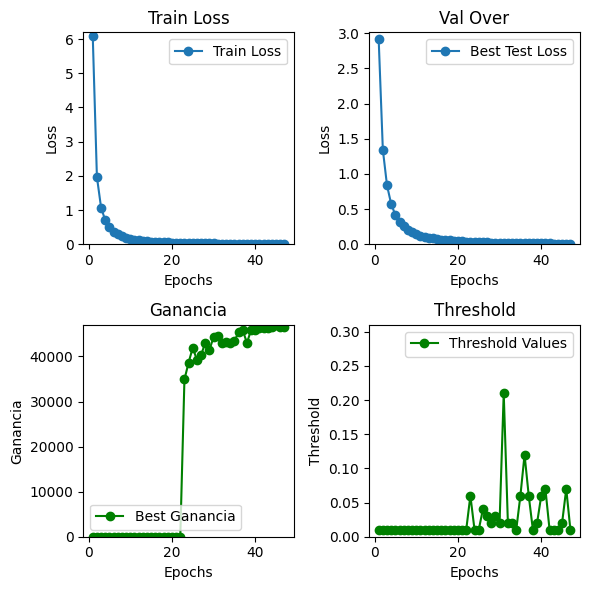

Epoch 48/300: 100%|██████████████████████| 92/92 [01:02<00:00,  1.48it/s, Train Loss=0.00802, CE Loss=1.16, Custom Loss=0.00172, Weight=0.501, T=0.74]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.09      0.00      0.00      1137
      BAJA+2       0.07      0.50      0.12      1248
    CONTINUA       0.88      0.95      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.84    183715
   macro avg       0.26      0.36      0.26    183715
weighted avg       0.78      0.84      0.81    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 11
BAJA+2: 9284
CONTINUA: 174420
OUT: 0
Saving model with best validation loss: 0.0078
Saving model with best ganancia: 47628

Epoch [48/300], Train Loss: 0.0080, Val Loss: 0.0078, Ganancia: 47628, Threshold: 0.05, LR: 5e-06


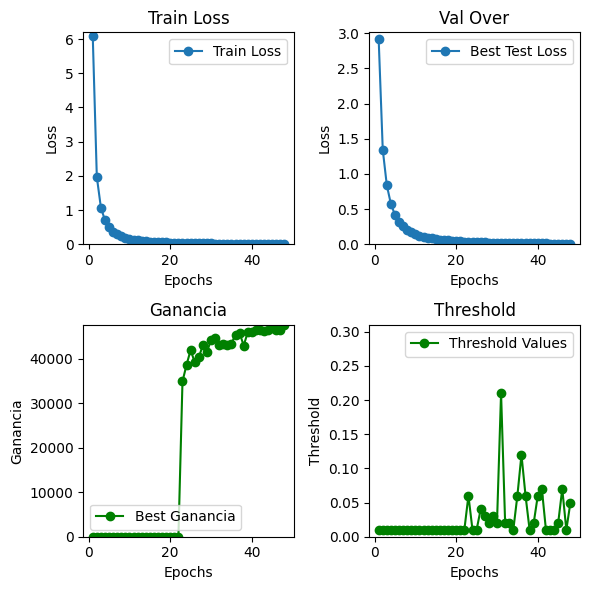

Epoch 49/300: 100%|██████████████████████| 92/92 [01:02<00:00,  1.47it/s, Train Loss=0.00764, CE Loss=1.2, Custom Loss=0.00163, Weight=0.501, T=0.746]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.04      0.02      0.02      1137
      BAJA+2       0.07      0.50      0.12      1248
    CONTINUA       0.88      0.95      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.84    183715
   macro avg       0.25      0.37      0.26    183715
weighted avg       0.78      0.84      0.81    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 475
BAJA+2: 9172
CONTINUA: 174068
OUT: 0
Saving model with best validation loss: 0.0075

Epoch [49/300], Train Loss: 0.0076, Val Loss: 0.0075, Ganancia: 47604, Threshold: 0.43, LR: 5e-06


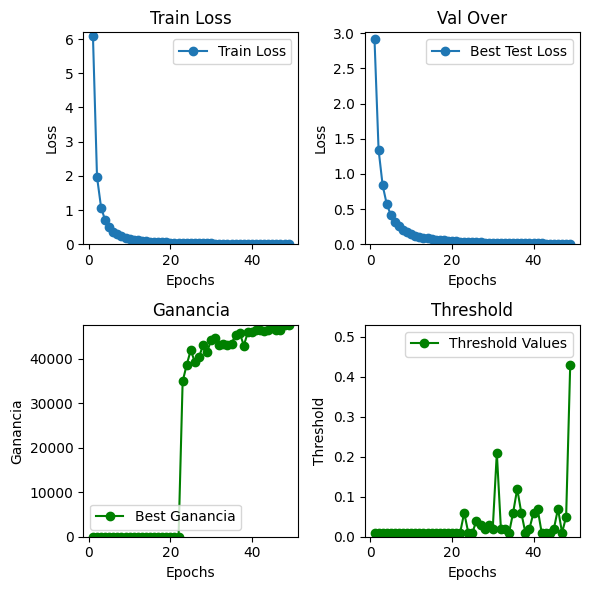

Epoch 50/300: 100%|███████████████████████| 92/92 [01:03<00:00,  1.44it/s, Train Loss=0.0073, CE Loss=1.07, Custom Loss=0.0016, Weight=0.501, T=0.751]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.03      0.02      0.03      1137
      BAJA+2       0.07      0.50      0.12      1248
    CONTINUA       0.88      0.95      0.91    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.84    183715
   macro avg       0.25      0.37      0.27    183715
weighted avg       0.78      0.84      0.81    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 833
BAJA+2: 9132
CONTINUA: 173750
OUT: 0
Saving model with best validation loss: 0.0072

Epoch [50/300], Train Loss: 0.0073, Val Loss: 0.0072, Ganancia: 47484, Threshold: 0.48, LR: 5e-06


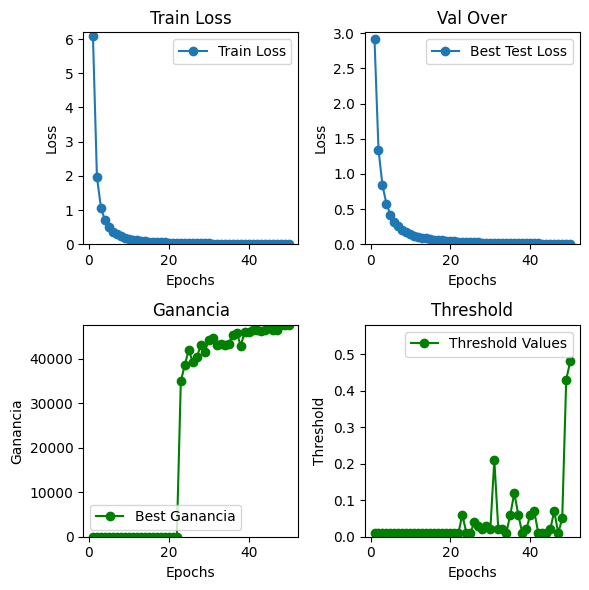

Epoch 51/300: 100%|█████████████████████| 92/92 [01:02<00:00,  1.46it/s, Train Loss=0.00697, CE Loss=1.19, Custom Loss=0.00134, Weight=0.501, T=0.757]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.04      0.00      0.00      1137
      BAJA+2       0.07      0.50      0.12      1248
    CONTINUA       0.88      0.95      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.84    183715
   macro avg       0.25      0.36      0.26    183715
weighted avg       0.78      0.84      0.81    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 54
BAJA+2: 8909
CONTINUA: 174752
OUT: 0
Saving model with best validation loss: 0.0067

Epoch [51/300], Train Loss: 0.0070, Val Loss: 0.0067, Ganancia: 47433, Threshold: 0.16, LR: 5e-06


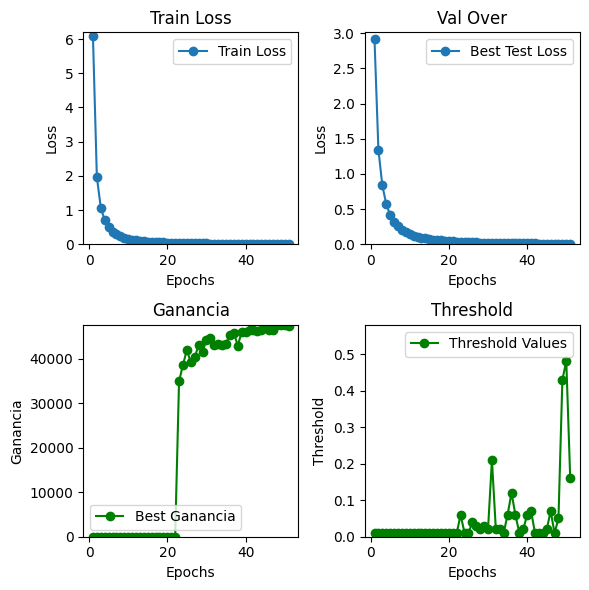

Epoch 52/300: 100%|██████████████████████| 92/92 [01:03<00:00,  1.46it/s, Train Loss=0.00666, CE Loss=1.1, Custom Loss=0.00148, Weight=0.501, T=0.762]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.02      0.00      0.01      1137
      BAJA+2       0.07      0.51      0.12      1248
    CONTINUA       0.88      0.95      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.84    183715
   macro avg       0.24      0.37      0.26    183715
weighted avg       0.78      0.84      0.81    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 168
BAJA+2: 9535
CONTINUA: 174012
OUT: 0
Saving model with best validation loss: 0.0065

Epoch [52/300], Train Loss: 0.0067, Val Loss: 0.0065, Ganancia: 47595, Threshold: 0.30, LR: 5e-06


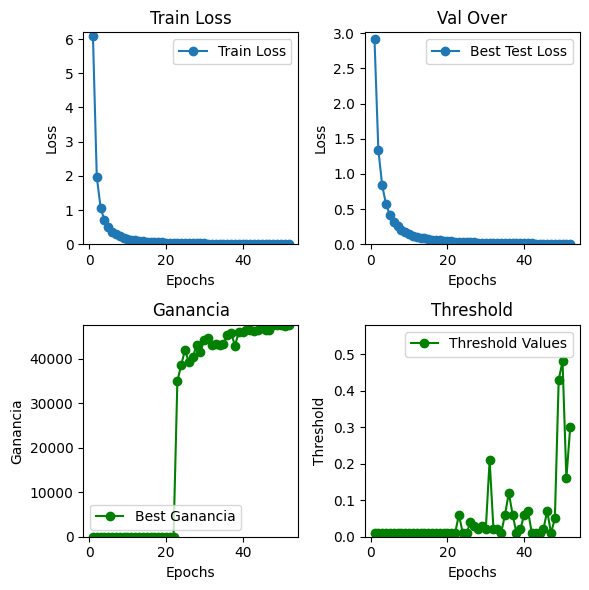

Epoch 53/300: 100%|██████████████████████| 92/92 [01:03<00:00,  1.45it/s, Train Loss=0.00635, CE Loss=1.1, Custom Loss=0.00132, Weight=0.501, T=0.767]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.03      0.02      0.02      1137
      BAJA+2       0.07      0.50      0.12      1248
    CONTINUA       0.88      0.94      0.91    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.84    183715
   macro avg       0.24      0.37      0.26    183715
weighted avg       0.78      0.84      0.81    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 879
BAJA+2: 9396
CONTINUA: 173440
OUT: 0
Saving model with best validation loss: 0.0063

Epoch [53/300], Train Loss: 0.0064, Val Loss: 0.0063, Ganancia: 47292, Threshold: 0.47, LR: 5e-06


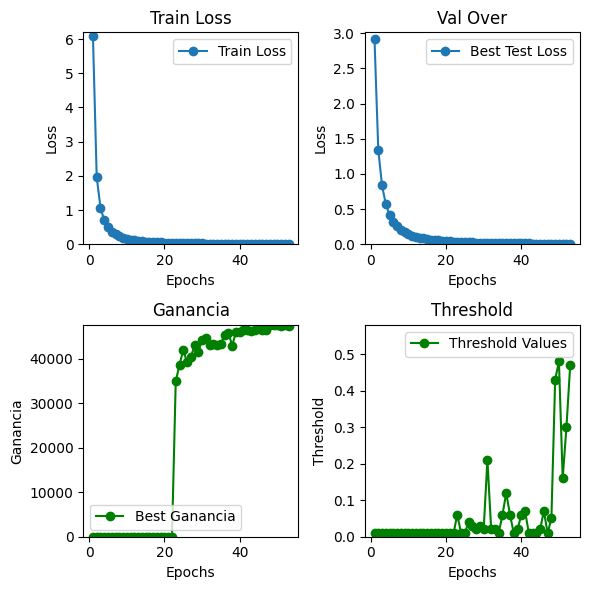

Epoch 54/300: 100%|█████████████████████| 92/92 [01:02<00:00,  1.46it/s, Train Loss=0.00608, CE Loss=1.07, Custom Loss=0.00107, Weight=0.501, T=0.773]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.03      0.02      0.02      1137
      BAJA+2       0.07      0.51      0.12      1248
    CONTINUA       0.88      0.95      0.91    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.84    183715
   macro avg       0.25      0.37      0.26    183715
weighted avg       0.78      0.84      0.81    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 642
BAJA+2: 9419
CONTINUA: 173654
OUT: 0
Saving model with best validation loss: 0.0060

Epoch [54/300], Train Loss: 0.0061, Val Loss: 0.0060, Ganancia: 47583, Threshold: 0.40, LR: 5e-06


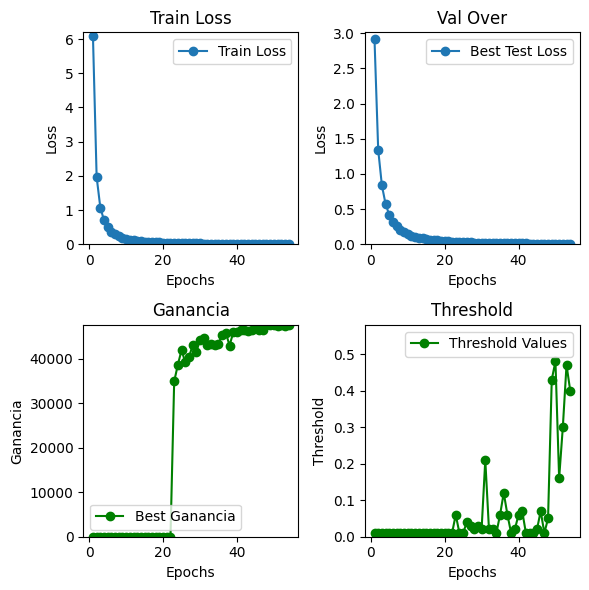

Epoch 55/300: 100%|█████████████████████| 92/92 [01:02<00:00,  1.47it/s, Train Loss=0.00584, CE Loss=1.09, Custom Loss=0.00115, Weight=0.501, T=0.778]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.06      0.00      0.01      1137
      BAJA+2       0.07      0.51      0.12      1248
    CONTINUA       0.88      0.95      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.84    183715
   macro avg       0.25      0.37      0.26    183715
weighted avg       0.78      0.84      0.81    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 82
BAJA+2: 9557
CONTINUA: 174076
OUT: 0
Saving model with best validation loss: 0.0057

Epoch [55/300], Train Loss: 0.0058, Val Loss: 0.0057, Ganancia: 47409, Threshold: 0.23, LR: 5e-06


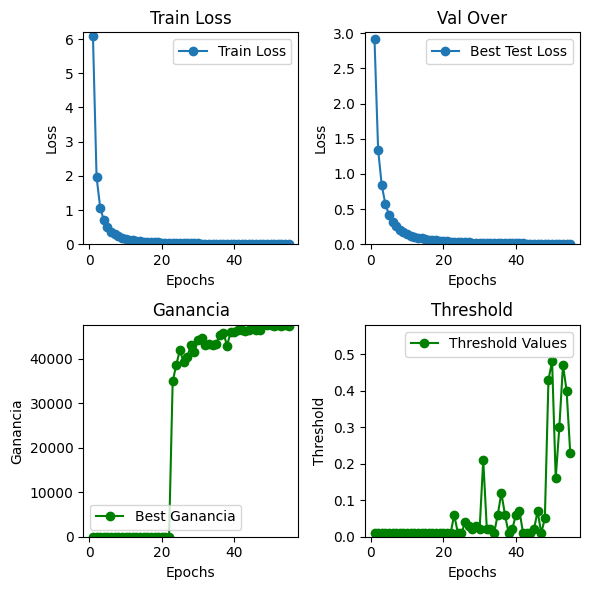

Epoch 56/300: 100%|█████████████████████| 92/92 [01:02<00:00,  1.48it/s, Train Loss=0.00557, CE Loss=1.06, Custom Loss=0.00109, Weight=0.501, T=0.783]



Classification Report for Last Timestep with Best Threshold:
              precision    recall  f1-score   support

      BAJA+1       0.05      0.00      0.01      1137
      BAJA+2       0.07      0.50      0.12      1248
    CONTINUA       0.88      0.95      0.92    162211
         OUT       0.00      0.00      0.00     19119

    accuracy                           0.84    183715
   macro avg       0.25      0.36      0.26    183715
weighted avg       0.78      0.84      0.81    183715


Class Counts (Predicted for Last Timestep):
BAJA+1: 56
BAJA+2: 9451
CONTINUA: 174208
OUT: 0
Saving model with best validation loss: 0.0054

Epoch [56/300], Train Loss: 0.0056, Val Loss: 0.0054, Ganancia: 47247, Threshold: 0.18, LR: 5e-06


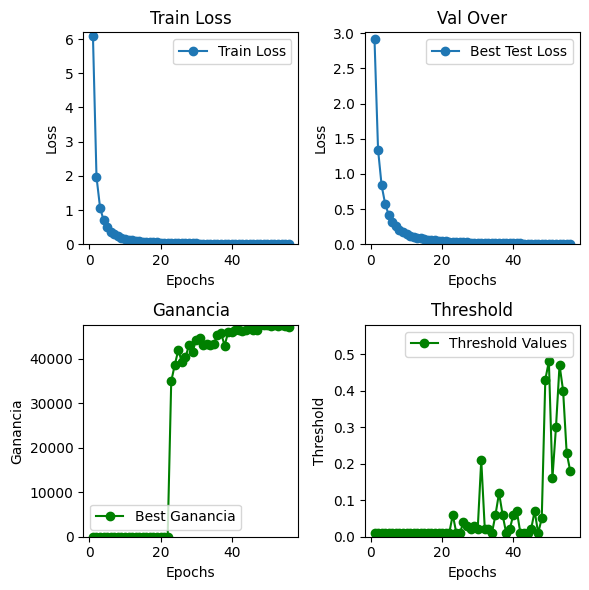

Epoch 57/300:  25%|█████▎               | 23/92 [00:15<00:47,  1.44it/s, Train Loss=0.00136, CE Loss=1.21, Custom Loss=0.00108, Weight=0.501, T=0.785]

In [ ]:
input_dim = 306  # Number of features per time step in your data
d_model = 256    # Model dimensionality (you can adjust this based on the task)
num_heads = 8    # Number of attention heads
num_layers = 4   # Number of Transformer layers
num_classes = 4  # Number of output classes ('BAJA+1', 'BAJA+2', 'CONTINUA', 'OUT')

# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using: " + device)


model = TransformerModel(input_dim=input_dim, d_model=d_model, num_heads=num_heads, num_layers=num_layers, num_classes=num_classes)


#criterion = nn.CrossEntropyLoss()

class_weights = torch.tensor([50.0, 70.0, 1.0, 1.0], dtype=torch.float32).to(device)
#class_weights = torch.tensor(class_weights, dtype=torch.float32, device=device)

# Initialize the criterion with class weights and a focus multiplier for BAJA+2
criterion = CustomGananciaLoss(class_weights=class_weights, baja_2_multiplier=2.0)

#optimizer = optim.Adam(list(model.parameters()) + [criterion.baja_2_threshold], lr=0.000003, weight_decay=1e-5)

optimizer = optim.Adam([
    {'params': model.parameters(), 'lr': 0.000005, 'weight_decay': 1e-5},  # Regular model parameters with weight decay
    {'params': [criterion.baja_2_threshold], 'lr': 0.001, 'weight_decay': 0.0}  # Higher learning rate for threshold, no weight decay
])





# Set number of epochs
num_epochs = 300


# Call train_model with the device set to 'cuda' or 'cpu'
train_model_with_teacher_forcing(model, train_loader, val_loader, criterion, optimizer, num_epochs=num_epochs, device=device)


In [ ]:
import copy
import sys
import random
import pickle
import torch
import warnings
import logging
import gc
import math
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pytorch_optimizer as optim_mod

from torch.optim import Optimizer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from collections import Counter
from tqdm import tqdm
from sklearn.exceptions import UndefinedMetricWarning

from torch.cuda.amp import autocast, GradScaler
from IPython.display import display, HTML

from collections import defaultdict
from sklearn.model_selection import StratifiedKFold

from scipy.stats import mode

from IPython.display import Javascript, display

In [ ]:
# Load the sequences and labels arrays
loaded_data_sequences = np.load('sequence_array_filtered_TRAINING3.npz', allow_pickle=True)
loaded_data_labels = np.load('label_array_filtered_TRAINING3.npz', allow_pickle=True)

# Access the saved arrays
sequence_array = loaded_data_sequences['sequences']
label_array = loaded_data_labels['labels']

print("Arrays loaded successfully!")

sequence_array.shape[:]


In [ ]:
# Remove the first feature (client ID) from the sequence array and the last two timesteps
sequence_array = sequence_array[:, :-2, 1:]  # Remove client ID (first feature) and last two timesteps
label_array = label_array[:, :-2]  # Remove the last two timesteps from the label array

print("Shapes after cleaning:")
print("sequence_array_cleaned shape:", sequence_array.shape)
print("label_array_cleaned shape:", label_array.shape)

In [ ]:
def split_data(sequence_array, label_array, train_steps, val_steps, test_steps):
    num_timesteps = sequence_array.shape[1]  # Total number of time steps

    # Ensure there are enough steps for training, validation, and testing
    assert train_steps + val_steps + test_steps <= num_timesteps, "Not enough steps for train/val/test."

    # Train on the first `train_steps` time steps (view without copying memory)
    X_train = sequence_array[:, :train_steps, :]  # Shape: [batch_size, 27, num_features]
    y_train = label_array[:, :train_steps]        # Shape: [batch_size, 27]

    # Validation on the first `train_steps + val_steps` time steps
    X_val = sequence_array[:, :train_steps + val_steps, :]  # Shape: [batch_size, 29, num_features]
    y_val = label_array[:, :train_steps + val_steps]        # Shape: [batch_size, 29]

    # Test on the entire sequence (31 steps)
    X_test = sequence_array[:, :train_steps + val_steps + test_steps, :]  # Shape: [batch_size, 31, num_features]
    y_test = label_array[:, :train_steps + val_steps + test_steps]        # Shape: [batch_size, 31]

    return X_train, y_train, X_val, y_val, X_test, y_test


In [ ]:
def create_padding_mask(input_seq, pad_token=0):
    # Check if all features in a time step are equal to pad_token
    mask = (input_seq != pad_token).any(dim=-1).float().transpose(0, 1)  # Shape: [seq_len, batch_size]
    
    return mask


In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=33):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)  # Shape: (1, max_len, d_model)

    def forward(self, x):
        # Ensure self.encoding is on the same device as x
        encoding = self.encoding.to(x.device)  # Move encoding to the same device as x
        #print(f"Positional Encoding Input Shape: {x.shape}")
        x = x + encoding[:, :x.size(1), :]  # Add positional encoding to input
        #print(f"Positional Encoding Output Shape: {x.shape}")
        return x


class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=512, num_heads=8, num_layers=6, num_classes=4, dim_feedforward=2048, dropout=0.2):
        super(TransformerModel, self).__init__()
        
        # Linear projection to project input_dim (306) to d_model (512)
        self.linear_proj = nn.Linear(input_dim, d_model)
        
        # Positional encoding for d_model (512)
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Transformer encoder with a feedforward network
        encoder_layers = nn.TransformerEncoderLayer(d_model, num_heads, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        
        # Additional feedforward network after transformer encoder
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
            nn.ReLU()
        )
        
        # Final fully connected layer for classification
        self.fc = nn.Linear(d_model, num_classes)  # Output is number of classes

    def forward(self, src, src_key_padding_mask=None):
        # Project input to match the d_model (512 dimensions)
        src = self.linear_proj(src)  # Shape: [batch_size, seq_len, d_model]

        # Apply positional encoding
        src = self.pos_encoder(src)  # Shape remains: [batch_size, seq_len, d_model]

        # Pass through the transformer encoder
        output = self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask)

        # Apply feedforward network
        output = self.feedforward(output)  # Shape remains: [batch_size, seq_len, d_model]

        # Pass through the final fully connected layer for classification
        output = self.fc(output)  # Shape: [batch_size, seq_len, num_classes]

        return output  # Output predictions for each time step


In [ ]:
train_steps = 29
val_steps = 2
test_steps = 0  # Remaining steps for testing

X_train, y_train, X_val, y_val, X_test, y_test = split_data(sequence_array, label_array, train_steps, val_steps, test_steps)

# Encode labels for training, validation, and testing
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train.flatten()).reshape(y_train.shape)
y_val_encoded = label_encoder.transform(y_val.flatten()).reshape(y_val.shape)
y_test_encoded = label_encoder.transform(y_test.flatten()).reshape(y_test.shape)

# Print encoded class names and their mappings (optional for debugging)
class_names = label_encoder.classes_
class_mapping = {idx: class_name for idx, class_name in enumerate(class_names)}
print(f"Encoded Classes: {class_names}")
print(f"Class to Index Mapping: {class_mapping}")

In [ ]:
# Convert training, validation, and test data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)  # Ensure labels are long (int64)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)  # Ensure labels are long (int64)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)  # Ensure labels are long (int64)

# Define the number of clients to keep
num_clients = 30000

REDUCE = False

if REDUCE:
    # Slice the tensors to keep only the first 'num_clients' rows
    X_test_tensor_reduced = X_test_tensor[:num_clients]
    y_test_tensor_reduced = y_test_tensor[:num_clients]
    
    X_train_tensor_reduced = X_train_tensor[:num_clients]
    y_train_tensor_reduced = y_train_tensor[:num_clients]
    
    X_val_tensor_reduced = X_val_tensor[:num_clients]
    y_val_tensor_reduced = y_val_tensor[:num_clients]

    # Create TensorDatasets for training, validation, and test sets
    train_dataset = TensorDataset(X_train_tensor_reduced, y_train_tensor_reduced)
    val_dataset = TensorDataset(X_val_tensor_reduced, y_val_tensor_reduced)
    test_dataset = TensorDataset(X_test_tensor_reduced, y_test_tensor_reduced)
    
    # Print the new shapes to confirm the reduction
    print(X_test_tensor_reduced.shape)
    print(y_test_tensor_reduced.shape)
    
    print(X_train_tensor_reduced.shape)
    print(y_train_tensor_reduced.shape)
    
    print(X_val_tensor_reduced.shape)
    print(y_val_tensor_reduced.shape)

    all_labels = y_train_tensor_reduced.flatten().cpu().numpy()  # Convert to numpy array
else:
    # Create TensorDatasets for training, validation, and test sets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)


    print(X_test_tensor.shape[:])
    print(y_test_tensor.shape[:])
    
    print(X_train_tensor.shape[:])
    print(y_train_tensor.shape[:])
    
    print(X_val_tensor.shape[:])
    print(y_val_tensor.shape[:])

    all_labels = y_train_tensor.flatten().cpu().numpy()  # Convert to numpy array




In [ ]:
# Create DataLoaders
batch_size = 1500  # You can adjust this based on your memory

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
input_dim = 306  # Number of features per time step in your data
d_model = 512    # Model dimensionality (you can adjust this based on the task)
num_heads = 8    # Number of attention heads
num_layers = 8   # Number of Transformer layers
num_classes = 4  # Number of output classes ('BAJA+1', 'BAJA+2', 'CONTINUA', 'OUT')
dim_feedforward=2048
dropout=0.2

# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using: " + device)


In [ ]:
# Load the state dict (but don't load it into a model yet)
state_dict = torch.load('best_model_ganancia.pth')

# Print the keys in the state dict to inspect the model's structure
#for key in state_dict.keys():
    #print(key)

In [ ]:
# Initialize the model (ensure it has the same architecture as the saved model)
model = TransformerModel(input_dim=input_dim, d_model=d_model, num_heads=num_heads, num_layers=num_layers, num_classes=num_classes, dim_feedforward=dim_feedforward, dropout=dropout)
model.load_state_dict(torch.load('best_model_ganancia.pth'))  # Load the saved state dict
model = model.to(device)  # Move to the appropriate device (GPU or CPU)

# Set the model to evaluation mode
model.eval()

In [ ]:
def calculate_best_threshold_ganancia(pred_probs, labels, thresholds, baja_2_index=1):

    best_ganancia = float('-inf')
    best_threshold = 0.69
    best_preds = None

    for threshold in thresholds:
        # Make predictions using the current threshold for BAJA+2
        preds = np.argmax(pred_probs, axis=-1)  # Default argmax predictions
        baja_2_probs = pred_probs[:, baja_2_index]  # BAJA+2 probabilities

        # Apply the threshold for BAJA+2 classification
        preds[baja_2_probs >= threshold] = baja_2_index

        # Calculate ganancia for this threshold
        ganancia = calculate_ganancia(preds, labels)

        # Update if this threshold gives a better ganancia
        if ganancia > best_ganancia:
            best_ganancia = ganancia
            best_threshold = threshold
            best_preds = preds
            print(f"Best G: {best_ganancia}, T:{best_threshold}")

    return best_ganancia, best_threshold, best_preds

In [ ]:
def calculate_ganancia(preds, labels, baja_2_index=1):
    
    # Define reward for correct BAJA+2 and penalty for incorrect BAJA+2
    reward_baja_2 = 117
    penalty_baja_2 = -3

    # Convert predictions and labels to numpy arrays if they aren't already
    preds = np.array(preds)
    labels = np.array(labels)

    # Calculate the number of correct BAJA+2 predictions
    correct_baja_2 = np.sum((preds == baja_2_index) & (labels == baja_2_index))

    # Calculate the number of incorrect BAJA+2 predictions (predicted BAJA+2 but label is not BAJA+2)
    incorrect_baja_2 = np.sum((preds == baja_2_index) & (labels != baja_2_index))

    # Calculate the total ganancia
    ganancia = (reward_baja_2 * correct_baja_2) + (penalty_baja_2 * incorrect_baja_2)

    return ganancia

In [ ]:
# Initialize lists to store probabilities and labels
all_probs_last = []
all_labels_last = []

# Disable gradient calculation for evaluation
with torch.no_grad():
    for X_test_batch, y_test_batch in test_loader:
        # Move data to the device (GPU or CPU)
        X_test_batch = X_test_batch.to(device)
        y_test_batch = y_test_batch.to(device)

        # Create the key padding mask for the test data
        src_key_padding_mask = create_padding_mask(X_test_batch, pad_token=0).to(device)

        # Forward pass: Get model predictions
        outputs = model(X_test_batch, src_key_padding_mask)

        # Get probabilities for the last timestep
        last_timestep_probs = torch.softmax(outputs[:, -1, :], dim=-1)  # Shape: [batch_size, num_classes]

        # Collect predicted probabilities and true labels for the last timestep
        all_probs_last.append(last_timestep_probs.cpu().numpy())
        all_labels_last.append(y_test_batch[:, -1].cpu().numpy())  # Collect the labels for the last timestep

# Concatenate all predictions and labels for the last timestep
all_probs_last = np.concatenate(all_probs_last)
all_labels_last = np.concatenate(all_labels_last)

In [ ]:
# Define the thresholds to test
thresholds = np.arange(0.1, 1.0, 0.01)

# Call the calculate_best_threshold_ganancia function to get the best threshold and predictions
best_ganancia, best_threshold, best_preds = calculate_best_threshold_ganancia(all_probs_last, all_labels_last, thresholds)

# Evaluate the performance for the best threshold
from sklearn.metrics import classification_report

print("\nClassification Report for Last Timestep with Best Threshold:")
print(classification_report(all_labels_last, best_preds, target_names=['BAJA+1', 'BAJA+2', 'CONTINUA', 'OUT']))

# Print the best ganancia and best threshold
print(f"Best Ganancia: {best_ganancia:.4f}, Best Threshold: {best_threshold:.4f}")

In [ ]:
import copy
import sys
import random
import pickle
import torch
import warnings
import logging
import gc
import math
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pytorch_optimizer as optim_mod

from torch.optim import Optimizer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from collections import Counter
from tqdm import tqdm
from sklearn.exceptions import UndefinedMetricWarning

from torch.cuda.amp import autocast, GradScaler
from IPython.display import display, HTML

from collections import defaultdict
from sklearn.model_selection import StratifiedKFold

from scipy.stats import mode

from IPython.display import Javascript, display

In [ ]:
# Load the sequences and labels arrays
loaded_data_sequences = np.load('sequence_array_filtered_INFERENCE.npz', allow_pickle=True)
loaded_data_labels = np.load('label_array_filtered_INFERENCE.npz', allow_pickle=True)

# Access the saved arrays
sequence_array = loaded_data_sequences['sequences']
label_array = loaded_data_labels['labels']
label_array = label_array[:, :, :-2]  # Remove the last two timesteps from the label array

print("Array loaded successfully!")

In [ ]:
print(label_array.shape[:])
print(sequence_array.shape[:])

In [ ]:
numero_de_cliente = sequence_array[:, :, 0, 0]

In [ ]:
sequence_array = sequence_array[:, :, :, 1:]  # Remove client ID (first feature)
print(sequence_array.shape[:])

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

In [ ]:
# Initialize a LabelEncoder
label_encoder = LabelEncoder()

# Flatten the label array and encode the labels as integers
label_array_flat = label_array.flatten()  # Flattening the array for label encoding
label_array_encoded = label_encoder.fit_transform(label_array_flat)

# Reshape it back to the original shape after encoding
label_array_encoded = label_array_encoded.reshape(label_array.shape)

# Print encoded classes for verification
class_names = label_encoder.classes_
print(f"Encoded Classes: {class_names}")

In [ ]:
print(label_array_encoded.shape[:])

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=33):
        super(PositionalEncoding, self).__init__()
        self.encoding = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)
        self.encoding = self.encoding.unsqueeze(0)  # Shape: (1, max_len, d_model)

    def forward(self, x):
        # Ensure self.encoding is on the same device as x
        encoding = self.encoding.to(x.device)  # Move encoding to the same device as x
        #print(f"Positional Encoding Input Shape: {x.shape}")
        x = x + encoding[:, :x.size(1), :]  # Add positional encoding to input
        #print(f"Positional Encoding Output Shape: {x.shape}")
        return x


class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=512, num_heads=8, num_layers=6, num_classes=4, dim_feedforward=2048, dropout=0.2):
        super(TransformerModel, self).__init__()
        
        # Linear projection to project input_dim (306) to d_model (512)
        self.linear_proj = nn.Linear(input_dim, d_model)
        
        # Positional encoding for d_model (512)
        self.pos_encoder = PositionalEncoding(d_model)
        
        # Transformer encoder with a feedforward network
        encoder_layers = nn.TransformerEncoderLayer(d_model, num_heads, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        
        # Additional feedforward network after transformer encoder
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim_feedforward, d_model),
            nn.ReLU()
        )
        
        # Final fully connected layer for classification
        self.fc = nn.Linear(d_model, num_classes)  # Output is number of classes

    def forward(self, src, src_key_padding_mask=None):
        # Project input to match the d_model (512 dimensions)
        src = self.linear_proj(src)  # Shape: [batch_size, seq_len, d_model]

        # Apply positional encoding
        src = self.pos_encoder(src)  # Shape remains: [batch_size, seq_len, d_model]

        # Pass through the transformer encoder
        output = self.transformer_encoder(src, src_key_padding_mask=src_key_padding_mask)

        # Apply feedforward network
        output = self.feedforward(output)  # Shape remains: [batch_size, seq_len, d_model]

        # Pass through the final fully connected layer for classification
        output = self.fc(output)  # Shape: [batch_size, seq_len, num_classes]

        return output  # Output predictions for each time step


In [ ]:
def create_padding_mask(input_seq, pad_token=0):
    # Check if all features in a time step are equal to pad_token
    mask = (input_seq != pad_token).any(dim=-1).float().transpose(0, 1)  # Shape: [seq_len, batch_size]
    
    return mask


In [ ]:
input_dim = 306  # Number of features per time step in your data
d_model = 512    # Model dimensionality (you can adjust this based on the task)
num_heads = 8    # Number of attention heads
num_layers = 8   # Number of Transformer layers
num_classes = 4  # Number of output classes ('BAJA+1', 'BAJA+2', 'CONTINUA', 'OUT')
dim_feedforward=2048
dropout=0.2

# Check if CUDA is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Using: " + device)

In [ ]:
# Initialize the model (ensure it has the same architecture as the saved model)
model = TransformerModel(input_dim=input_dim, d_model=d_model, num_heads=num_heads, num_layers=num_layers, num_classes=num_classes, dim_feedforward=dim_feedforward, dropout=dropout)
model.load_state_dict(torch.load('best_model_ganancia.pth'))  # Load the saved state dict
model = model.to(device)  # Move to the appropriate device (GPU or CPU)

# Set the model to evaluation mode
model.eval()

In [ ]:
sequence_tensor = torch.tensor(sequence_array, dtype=torch.float32).squeeze(1).to(device) 

In [ ]:

# Define batch size
batch_size = 256

# Prepare DataLoader for the sequence_tensor
test_dataset = TensorDataset(sequence_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize lists to collect the predictions
all_probs_last = []

# Disable gradient calculation for inference
with torch.no_grad():
    progress_bar = tqdm(test_loader, desc="Inference", leave=False)
    
    for batch in progress_bar:
        # Extract the sequences from the batch and move to device
        X_test_batch = batch[0].to(device)

        # Create the key padding mask for the test data
        src_key_padding_mask = create_padding_mask(X_test_batch, pad_token=0).to(device)

        # Forward pass: Get model predictions
        outputs = model(X_test_batch, src_key_padding_mask)

        # Get probabilities for the last timestep
        last_timestep_probs = torch.softmax(outputs[:, -1, :], dim=-1).cpu().numpy()  # Shape: [batch_size, num_classes]

        # Collect predicted probabilities for the last timestep
        all_probs_last.append(last_timestep_probs)

all_probs_last = np.concatenate(all_probs_last, axis=0)

In [ ]:
# Define your parameters
fixed_threshold = 0.18  # Define your fixed threshold for the relevant class
relevant_class = 1     # Example: BAJA+2 class (assuming index 1)


# Get the predicted class based on argmax of softmax probabilities
predicted_classes = np.argmax(all_probs_last, axis=1)

# Extract probabilities for the relevant class (e.g., BAJA+2)
relevant_class_probs = all_probs_last[:, relevant_class]

# Apply the fixed threshold: if relevant_class_probs >= threshold, set class to relevant_class
predicted_classes[relevant_class_probs >= fixed_threshold] = relevant_class

# Save the predicted classes
y_pred = predicted_classes

In [ ]:
# Assuming y_pred contains the predicted classes
class_counts = Counter(y_pred)

# Map class indices to labels for better readability
class_labels = {0: 'BAJA+1', 1: 'BAJA+2', 2: 'CONTINUA', 3: 'OUT'}

# Display the counts for each class in order (0 -> BAJA+1, 1 -> BAJA+2, 2 -> CONTINUA, 3 -> OUT)
for class_index in sorted(class_labels.keys()):
    count = class_counts.get(class_index, 0)  # If a class has 0 counts, return 0
    print(f"{class_labels[class_index]}: {count}")

In [ ]:
# Convert 2 (CONTINUA) and 3 (OUT) to 0 (BAJA+1)
y_pred_converted = np.where((y_pred == 2) | (y_pred == 3), 0, y_pred)
#y_pred_converted = np.where((y_pred == 1) | (y_pred == 2) | (y_pred == 3), 5, y_pred)
#y_pred_converted = np.where((y_pred_converted == 0) , 1, y_pred_converted)
#y_pred_converted = np.where((y_pred_converted == 5) , 0, y_pred_converted)

# Check the new class distribution after conversion
class_counts_converted = Counter(y_pred_converted)

# Display the counts for each class in order (0 -> BAJA+1, 1 -> BAJA+2, 2 -> CONTINUA, 3 -> OUT)
for class_index in sorted(class_labels.keys()):
    count = class_counts_converted.get(class_index, 0)  # If a class has 0 counts, return 0
    print(f"{class_labels[class_index]}: {count}")

In [ ]:
y_pred_converted = y_pred_converted.astype(int)
numero_de_cliente_flat = numero_de_cliente.flatten()
numero_de_cliente_flat = numero_de_cliente_flat.astype(int)
submission_df = pd.DataFrame({
    'numero_de_cliente': numero_de_cliente_flat,
    'Predicted': y_pred_converted
})


In [ ]:
# Ensure the submission file has exactly 165,093 rows (as specified in your requirements)
assert submission_df.shape[0] == 165093, "The submission file must have exactly 165,093 rows."

# Save the first submission file
print("Saving submission file...")
submission_df.to_csv('submissionNoForce.csv', index=False)
print("Submission file saved as 'submissionNoForce.csv'")


In [ ]:
import gzip
import shutil

# Compress the submission.csv file
with open('submissionNoForce.csv', 'rb') as f_in:
    with gzip.open('submissionNoForce.csv.gz', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

print("gzip done")